In [2]:
import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform, Laplace
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store

from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 

import sys 
sys.path.append('../..')
from delphi.stats.linear_regression import TruncatedRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata

OUT_DIR = '/home/gridsan/stefanou/Regression/'
TABLE_NAME = 'logs'

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [3]:
args = Parameters({
    "bias": True,
    "samples": 10000,
    "c": 0,
    "batch_size": 5,
    "lr": 1e-1,
    "var_lr": 1e-2,
    "var_": 1,
    "trials": 3,
    "norm": False,
    "workers": 8,
    "steps": 1000,
    "x_lower": -10,
    "x_upper": 10,
    "lower": -1,
    "upper": 1,
    "device": "cuda",
    "num_samples": 100,
})
mse_loss = ch.nn.MSELoss()

I will start by generating the ground-truth for our expriment.

gt weight:  Parameter containing:
tensor([[-0.7730]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[0.5748]], requires_grad=True)
alpha:  tensor([0.6926])
gt ols coef:  [[-0.77721226]]
gt ols intercept:  [0.59251046]
trunc ols coef:  [[-0.50018835]]
trunc ols intercept:  [1.0499281]


Text(0, 0.5, 'y')

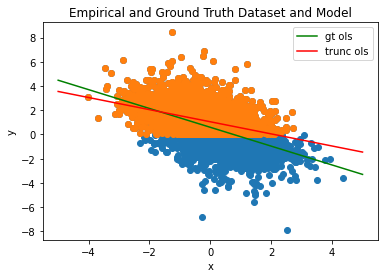

In [18]:
# distribution for generating feature vectors
d, k = 1, 1
w = Uniform(-1, 1)
m = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
# m = Uniform(-5, 5)
phi = oracle.Left(Tensor([0.0]))
# phi = oracle.Identity()

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None

print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))
    y = gt(X)

noise_var = ch.ones(1)
noise_scale = ch.sqrt(noise_var/2)
laplace = Laplace(ch.zeros(1), noise_scale)
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + laplace.sample(ch.Size([X.size(0)]))
    # truncate based off of the standardized data
    indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
unnorm_data = np.linspace(-5, 5, 100).reshape(100, 1)
norm_data = np.linspace(-1, 1, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we want to standardize our truncated dataset, so that our empirical estimates are located on the l2 ball. First we will divide all of our covariate features by $B\sqrt{k}$, so that all of our covariate features $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. This way the norm of $w$ will be multiplied by $B\sqrt{k}$.

In [19]:
max_x_trunc_norm = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
print("max truncated x norm", max_x_trunc_norm)

beta = max_x_trunc_norm*math.sqrt(X.size(1))
print("beta: ", beta)

x_trunc_norm = x_trunc / beta
print("x max l2: ", x_trunc_norm.norm(dim=-1).max())

max truncated x norm tensor(4.0143)
beta:  tensor(4.0143)
x max l2:  tensor(1.)


We now observe that the norm of the truncated x covariates is bounded by 1. So, now we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1. First, let's calculate the predicted values from our naive ols regression on teh truncated data.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([0.6316])
trunc reg noise var:  tensor([2.0522])


Text(0, 0.5, 'y')

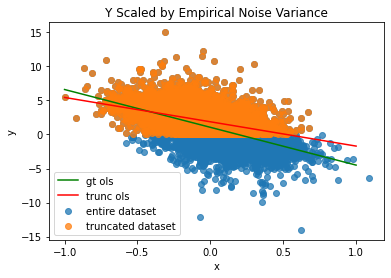

In [52]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)
emp_noise_scale = ch.sqrt(emp_noise_var/2) 

emp_stand_y_trunc = y_trunc / emp_noise_scale
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

new_X, emp_stand_noised = X / beta, noised / emp_noise_scale

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(new_X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc_norm, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

First, we will standardize our data for the case where we assume that wee know the underlying ground-truth noise variance.

trunc reg noise var:  tensor([1.2631])
reg noise var:  tensor([2.0303])


Text(0, 0.5, 'y')

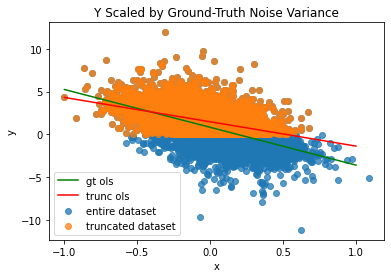

In [53]:
stand_noised, stand_y_trunc = noised / noise_scale, y_trunc / noise_scale

gt_stand = LinearRegression()
gt_stand.fit(new_X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc_norm, stand_y_trunc)

trunc_noise_var = (stand_y_trunc - trunc_stand_ols.predict(x_trunc_norm)).var(0)
print("trunc reg noise var: ", trunc_noise_var)

reg_noise_var = (stand_noised - gt_stand.predict(new_X)).var(0)
print("reg noise var: ", reg_noise_var)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Empirical Variance

In [54]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=True, unknown=False, val=100, bs=10, n=100, tol=1e-2)
known_emp_res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
known_emp_w_unnorm = (known_emp_res.weight * emp_noise_scale) / beta

known_emp_bias_unnorm = ch.zeros(1, 1)
if args.bias: 
    known_emp_bias_unnorm = (known_emp_res.bias * emp_noise_scale)

0 steps | score: [0.08722872287034988]
100 steps | score: [-0.15371833741664886]
200 steps | score: [0.11577165126800537]
300 steps | score: [0.15002448856830597]
400 steps | score: [-0.040850937366485596]
500 steps | score: [0.04271867498755455]
600 steps | score: [0.01830844022333622]
700 steps | score: [0.04730379208922386]
800 steps | score: [-0.052826348692178726]
900 steps | score: [0.10823661088943481]
1000 steps | score: [0.08567563444375992]
1100 steps | score: [-0.0640784278512001]
1200 steps | score: [0.008505544625222683]


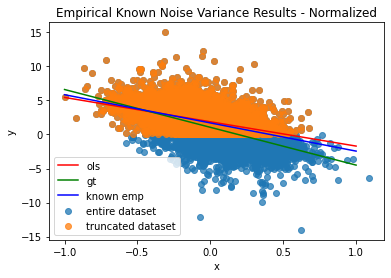

Text(0, 0.5, 'y')

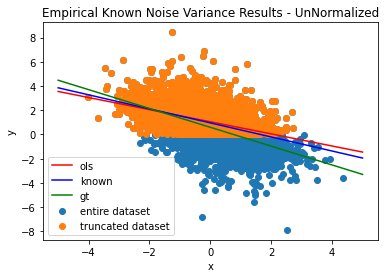

In [55]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_emp_res(Tensor(norm_data)).detach().numpy(), label='known emp', color='blue')
plt.legend()
plt.title("Empirical Known Noise Variance Results - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='ols')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_emp_w_unnorm + known_emp_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Variance

In [58]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=args.bias, unknown=False, val=100, bs=1, n=100, tol=1e-2, steps=2000)
known_res = trunc_reg.fit(x_trunc_norm, stand_y_trunc)
known_weight_unnorm = (known_res.weight * noise_scale) / beta

known_bias_unnorm = ch.zeros(1, 1)
if args.bias:  
    known_bias_unnorm = known_res.bias * noise_scale

0 steps | score: [0.1404706835746765]
100 steps | score: [-0.20729883015155792]
200 steps | score: [-0.019203443080186844]
300 steps | score: [0.15922656655311584]
400 steps | score: [0.26590561866760254]
500 steps | score: [-0.19839715957641602]
600 steps | score: [-0.07279006391763687]
700 steps | score: [0.047994550317525864]
800 steps | score: [0.07560958713293076]
900 steps | score: [0.0676669031381607]
1000 steps | score: [-0.28352153301239014]
1100 steps | score: [0.052644044160842896]
1200 steps | score: [-0.017157278954982758]
1300 steps | score: [-0.22028736770153046]
1400 steps | score: [-0.1377340853214264]
1500 steps | score: [0.0061187297105789185]


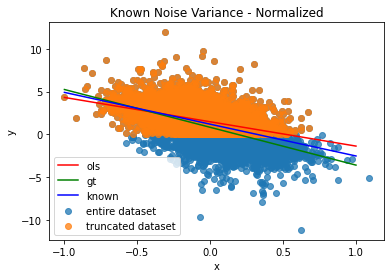

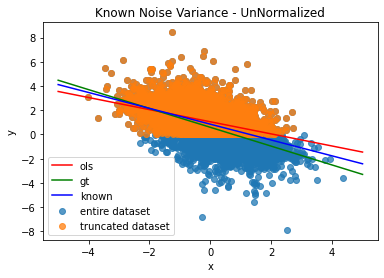

In [59]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_res(Tensor(norm_data)).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='r', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_weight_unnorm + known_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Truncated Regression with Unknown Noise Variance

In [60]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=True, unknown=True, bs=1, n=100, tol=5e-2, val=100, steps=2000)
unknown_res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
unknown_var = unknown_res.lambda_.inverse()
unknown_weight_unnorm, unknown_bias_unnorm = (((unknown_res.weight * unknown_var) * emp_noise_scale) / beta).detach().numpy(), ((unknown_res.bias * unknown_var) * emp_noise_scale).detach().numpy()

0 steps | score: [0.2905574440956116, -0.20666351914405823]
100 steps | score: [-0.27120140194892883, -3.2981948852539062]
200 steps | score: [-1.2057424783706665, 2.8927805423736572]
300 steps | score: [-0.8965381383895874, 2.547687530517578]
400 steps | score: [-1.3437919616699219, 3.0747432708740234]
500 steps | score: [-0.338600754737854, 1.6003186702728271]
600 steps | score: [-0.18581794202327728, 1.1041582822799683]
700 steps | score: [-2.0519609451293945, 3.499739170074463]
800 steps | score: [-0.5100373029708862, 1.8548325300216675]
900 steps | score: [-0.8865644335746765, 2.509981870651245]
1000 steps | score: [-0.5900213122367859, 2.0247135162353516]
1100 steps | score: [0.15984177589416504, 0.3845093250274658]
1200 steps | score: [0.22827421128749847, 0.23511837422847748]
1300 steps | score: [-0.3410768210887909, 1.496913194656372]
1400 steps | score: [-0.5526643395423889, 1.8662344217300415]
1500 steps | score: [0.03078850731253624, 0.7469772100448608]
1600 steps | score: 

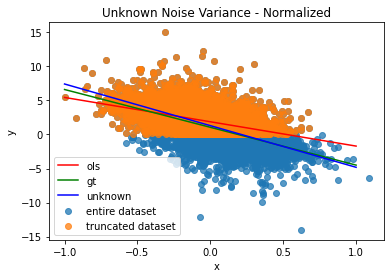

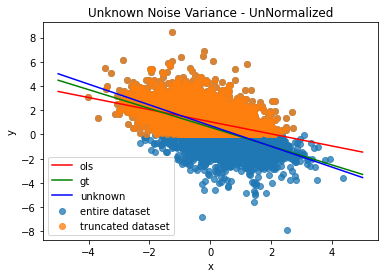

In [61]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, unknown_res(Tensor(norm_data)).detach().numpy(), label='unknown', color='blue')
plt.legend()
ax.set_title("Unknown Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), label='ols', color='red')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='g', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@unknown_weight_unnorm + unknown_bias_unnorm), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Truncate at Zero and Run for High Variance

In [7]:
args.__setattr__('bs', 10)
args.__setattr__('steps', 2500)
args.__setattr__('step_lr', 100)
args.__setattr__('step_lr_gamma', .9)
args.__setattr__('tol', 1e-2)
args.__setattr__('trials', 20)
args.__setattr__('samples', 1000)
args.__setattr__('n', 100)

EXP = '1KLaplace2DimsNoiseVar2.0'

In [8]:
def run_trial(kwargs, X, y):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > 3e-1) and attempt < 3:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time    

In [15]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 2, 1

# distribution for generating feature vectors
W = Uniform(w_lower, w_upper)
dist = Uniform(-5, 5)
noise_var = 2*ch.ones(1)
noise_scale = ch.sqrt(noise_var/2)
laplace = Laplace(ch.zeros(1), noise_scale)

C = [-2.5, -2, -1.75, -1.5, -1.25, -1.0, -.75, -.5, -.25, 0.0]



for i in range(args.trials):
    # create store and add table
    store = Store(OUT_DIR + EXP)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_l1': float,
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_time': int,
        'alpha': float, 
        'c': float,
        'num_samples': int,
        'noise_var': float, 
    })
    
    # generate ground truth
    gt = ch.nn.Linear(in_features=d, out_features=k)
    gt.weight = ch.nn.Parameter(W.sample(ch.Size([k, d])))
    gt.bias = ch.nn.Parameter(W.sample(ch.Size([1, 1]))) if args.bias else None
    
    # create base classifier
    with ch.no_grad():
        # generate data
        X = dist.sample(ch.Size([args.samples, d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([args.samples]))
        noised = gt(X) + laplace.sample(ch.Size([X.size(0)]))
        
    for c in C: 
        phi = oracle.Left(c)
        # add noise to ground-truth pedictions
        # truncate based off of the standardized data
        indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = noised[indices], X[indices]
        alpha = Tensor([y_trunc.size(0) / args.samples])
        print("alpha: ", alpha)
        
        val = int(.2*x_trunc.size(0))
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc_norm)).var(0)
        # standardize y trunc by the empirical noise variance
        emp_noise_scale = ch.sqrt(emp_noise_var/2) 
        emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)

        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by the empirical noise variance
        stand_y_trunc = y_trunc / ch.sqrt(noise_var)
        # standardize noised by the empirical noise variance
        known_kwargs = { 
            'phi': phi, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, stand_y_trunc)
        with ch.no_grad():
            w, w0 = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta, known_trunc_reg.intercept[..., None] * ch.sqrt(noise_var)
            known_params = ch.cat([w, w0]).flatten()
            
            # known results
            store[TABLE_NAME].update_row({
                'known_r2': r2_score(noised.flatten(), X@w + w0), 
                'known_param_mse': mse_loss(known_params, gt_params),
                'known_time': total_time, 
            })
        
        
        # truncated regression with unknown variance
        unknown_kwargs = { 
            'phi': phi, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, emp_stand_y_trunc)
    
        with ch.no_grad():
            w, w0 = (((unknown_trunc_reg.weight * unknown_trunc_reg.variance) * ch.sqrt(emp_noise_var)) / beta), ((unknown_trunc_reg.intercept * unknown_trunc_reg.variance * ch.sqrt(emp_noise_var)))
            unknown_params = ch.cat([w, w0]).flatten()

            # unknown results
            store[TABLE_NAME].update_row({
                'unknown_r2': r2_score(noised.flatten(), X@w + w0), 
                'unknown_param_mse': mse_loss(unknown_params, gt_params),
                'unknown_var_l1': float(ch.abs(unknown_trunc_reg.variance * noise_var - noise_var)),
                'unknown_time': total_time, 
            })
        
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_var': float(noise_var), 
            'c': c,
        })

        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

Logging in: /home/gridsan/stefanou/Regression/1KLaplace2DimsNoiseVar2.0/24c9ffaa-9fdd-42c8-98de-a4d7bfc94f5a
alpha:  tensor([0.8150])
Iteration: 0.0 | Score: [0.04722311347723007]
Iteration: 1.0 | Score: [0.06049702316522598]
Iteration: 2.0 | Score: [-0.024170825257897377]
Iteration: 3.0 | Score: [0.07589077949523926]
Iteration: 4.0 | Score: [-0.011573017574846745]
Iteration: 5.0 | Score: [0.09627564251422882]
Iteration: 6.0 | Score: [-0.04976837337017059]
Iteration: 7.0 | Score: [0.09433868527412415]
Iteration: 8.0 | Score: [-0.03343188017606735]
Iteration: 9.0 | Score: [0.07070616632699966]
Iteration: 10.0 | Score: [-0.007736103609204292]
Iteration: 0.0 | Score: [0.002937508746981621, 0.0449008084833622]
Iteration: 1.0 | Score: [-0.0009452835074625909, 0.06258276849985123]
Iteration: 2.0 | Score: [0.00915176048874855, 0.028034891933202744]
Iteration: 3.0 | Score: [0.043503694236278534, -0.020499564707279205]
Iteration: 4.0 | Score: [-0.01854443922638893, 0.06166984513401985]
Iteratio

Iteration: 15.0 | Score: [-0.10184691101312637, 0.1649831235408783]
Iteration: 16.0 | Score: [-0.10223791748285294, 0.16870157420635223]
Iteration: 17.0 | Score: [-0.09542949497699738, 0.14995497465133667]
Iteration: 18.0 | Score: [-0.08584609627723694, 0.14865611493587494]
Iteration: 19.0 | Score: [-0.11108727008104324, 0.1702890396118164]
Iteration: 20.0 | Score: [-0.08276986330747604, 0.13748085498809814]
Iteration: 21.0 | Score: [-0.09593689441680908, 0.1528758704662323]
Iteration: 22.0 | Score: [-0.09961975365877151, 0.16573117673397064]
Iteration: 23.0 | Score: [-0.10375577211380005, 0.17592719197273254]
Iteration: 24.0 | Score: [-0.10225113481283188, 0.1552841067314148]
Iteration: 25.0 | Score: [-0.08694141358137131, 0.14131061732769012]
alpha:  tensor([0.7050])
Iteration: 0.0 | Score: [0.20629170536994934]
Iteration: 1.0 | Score: [0.07259970903396606]
Iteration: 2.0 | Score: [0.19858863949775696]
Iteration: 3.0 | Score: [0.07945367693901062]
Iteration: 4.0 | Score: [0.050328105

Iteration: 4.0 | Score: [0.0504545234143734, -0.260405957698822]
Iteration: 5.0 | Score: [-0.023742549121379852, -0.13039535284042358]
Iteration: 6.0 | Score: [-0.011603886261582375, -0.14419253170490265]
Iteration: 7.0 | Score: [-0.04921846091747284, -0.07948698103427887]
Iteration: 8.0 | Score: [-0.08589072525501251, -0.016582490876317024]
Iteration: 9.0 | Score: [-0.09475646167993546, 0.0002295318990945816]
Iteration: 10.0 | Score: [-0.1008458137512207, -0.01841028220951557]
Iteration: 11.0 | Score: [-0.09127498418092728, -0.021241838112473488]
Iteration: 12.0 | Score: [-0.05547569319605827, -0.07658561319112778]
Iteration: 13.0 | Score: [-0.0584929920732975, -0.05018886551260948]
Iteration: 14.0 | Score: [-0.043897248804569244, -0.0923757553100586]
Iteration: 15.0 | Score: [-0.028632281348109245, -0.10906694829463959]
Iteration: 16.0 | Score: [-0.017312118783593178, -0.13157212734222412]
Iteration: 17.0 | Score: [-0.028494374826550484, -0.10414768010377884]
Iteration: 18.0 | Score:

Iteration: 19.0 | Score: [-0.04469814524054527, -0.03890753537416458]
Iteration: 20.0 | Score: [-0.0552925243973732, -0.03679736703634262]
Iteration: 21.0 | Score: [-0.036313533782958984, -0.049942709505558014]
Iteration: 22.0 | Score: [-0.05903735011816025, -0.029865793883800507]
Iteration: 23.0 | Score: [-0.03813327103853226, -0.04361346736550331]
Iteration: 24.0 | Score: [-0.05010192096233368, -0.03297530859708786]
Iteration: 25.0 | Score: [-0.042386796325445175, -0.03942722827196121]
alpha:  tensor([0.7950])
Iteration: 0.0 | Score: [0.10130805522203445]
Iteration: 1.0 | Score: [0.0809745043516159]
Iteration: 2.0 | Score: [-0.011171948164701462]
Iteration: 3.0 | Score: [0.07606683671474457]
Iteration: 4.0 | Score: [0.0037892330437898636]
Iteration: 0.0 | Score: [-0.030505117028951645, 0.12764164805412292]
Iteration: 1.0 | Score: [-0.021404117345809937, 0.07015074789524078]
Iteration: 2.0 | Score: [-0.10625363886356354, 0.16006800532341003]
Iteration: 3.0 | Score: [-0.059403542429208

Iteration: 21.0 | Score: [-0.1069195568561554, 0.005986337549984455]
Iteration: 22.0 | Score: [-0.10681087523698807, 0.01287612784653902]
Iteration: 23.0 | Score: [-0.09069189429283142, -0.0019542723894119263]
Iteration: 24.0 | Score: [-0.0907278060913086, 0.01217424776405096]
Iteration: 25.0 | Score: [-0.11613935977220535, 0.03624366968870163]
alpha:  tensor([0.6770])
Iteration: 0.0 | Score: [0.12452316284179688]
Iteration: 1.0 | Score: [0.055847570300102234]
Iteration: 2.0 | Score: [0.07592582702636719]
Iteration: 3.0 | Score: [0.0874963030219078]
Iteration: 4.0 | Score: [0.0511162132024765]
Iteration: 5.0 | Score: [-0.009790189564228058]
Iteration: 0.0 | Score: [-0.03511419519782066, 0.2155894935131073]
Iteration: 1.0 | Score: [-0.09707693755626678, 0.2220151722431183]
Iteration: 2.0 | Score: [-0.11079481989145279, 0.21346934139728546]
Iteration: 3.0 | Score: [-0.05403567850589752, 0.15853077173233032]
Iteration: 4.0 | Score: [-0.09297820925712585, 0.21055415272712708]
Iteration: 5.

Iteration: 15.0 | Score: [0.005735171027481556, 0.033348698168992996]
Iteration: 16.0 | Score: [-0.05741734430193901, 0.1223958432674408]
Iteration: 17.0 | Score: [0.00396770378574729, 0.025352392345666885]
Iteration: 18.0 | Score: [0.0003815599193330854, 0.03489244729280472]
Iteration: 19.0 | Score: [-0.03338497877120972, 0.08377275615930557]
Iteration: 20.0 | Score: [-0.005219811107963324, 0.04988495633006096]
Iteration: 21.0 | Score: [-0.026594316586852074, 0.08050288259983063]
Iteration: 22.0 | Score: [-0.020866502076387405, 0.08366204053163528]
Iteration: 23.0 | Score: [-0.06251230835914612, 0.12782928347587585]
Iteration: 24.0 | Score: [-0.03008567914366722, 0.07985672354698181]
Iteration: 25.0 | Score: [-0.027674103155732155, 0.10275374352931976]
alpha:  tensor([0.5280])
Iteration: 0.0 | Score: [0.3614656627178192]
Iteration: 1.0 | Score: [0.08640206605195999]
Iteration: 2.0 | Score: [0.1231776550412178]
Iteration: 3.0 | Score: [0.18600404262542725]
Iteration: 4.0 | Score: [0.08

Iteration: 12.0 | Score: [-0.12067608535289764]
Iteration: 13.0 | Score: [-0.16995558142662048]
Iteration: 14.0 | Score: [-0.15115199983119965]
Iteration: 15.0 | Score: [-0.1332605630159378]
Iteration: 16.0 | Score: [-0.14165747165679932]
Iteration: 17.0 | Score: [-0.15068258345127106]
Iteration: 18.0 | Score: [-0.1631772220134735]
Iteration: 19.0 | Score: [-0.1465061753988266]
Iteration: 20.0 | Score: [-0.15173281729221344]
Iteration: 21.0 | Score: [-0.1621207445859909]
Iteration: 22.0 | Score: [-0.15202642977237701]
Iteration: 23.0 | Score: [-0.14856819808483124]
Iteration: 24.0 | Score: [-0.15586070716381073]
Iteration: 25.0 | Score: [-0.13092492520809174]
Iteration: 0.0 | Score: [0.06964389979839325, -0.012554687447845936]
Iteration: 1.0 | Score: [0.04787066578865051, -0.011054502800107002]
Iteration: 2.0 | Score: [0.12521472573280334, -0.08367961645126343]
Iteration: 3.0 | Score: [0.08492138981819153, -0.04028933122754097]
Iteration: 4.0 | Score: [0.04830727353692055, -0.007461172

Iteration: 4.0 | Score: [-0.031038157641887665]
Iteration: 5.0 | Score: [0.017789242789149284]
Iteration: 6.0 | Score: [-0.014781344681978226]
Iteration: 7.0 | Score: [-0.04330405592918396]
Iteration: 8.0 | Score: [-0.042744603008031845]
Iteration: 9.0 | Score: [-0.0563080832362175]
Iteration: 10.0 | Score: [-0.05278332903981209]
Iteration: 11.0 | Score: [-0.062494128942489624]
Iteration: 12.0 | Score: [-0.032141704112291336]
Iteration: 13.0 | Score: [-0.03828131780028343]
Iteration: 14.0 | Score: [-0.020008616149425507]
Iteration: 15.0 | Score: [-0.008644500747323036]
Iteration: 0.0 | Score: [-0.010544611141085625, 0.023887567222118378]
Iteration: 1.0 | Score: [-0.027777351438999176, -0.010661927983164787]
Iteration: 2.0 | Score: [-0.03819848969578743, -0.006782707758247852]
Iteration: 3.0 | Score: [-0.01790187694132328, -0.02817671373486519]
Iteration: 4.0 | Score: [-0.04894445836544037, 0.0033334423787891865]
Iteration: 5.0 | Score: [-0.07758159935474396, 0.04921134561300278]
Iterat

Iteration: 18.0 | Score: [0.07832472771406174]
Iteration: 19.0 | Score: [0.07338204234838486]
Iteration: 20.0 | Score: [0.06194797158241272]
Iteration: 21.0 | Score: [0.07297393679618835]
Iteration: 22.0 | Score: [0.06574784964323044]
Iteration: 23.0 | Score: [0.0769457221031189]
Iteration: 24.0 | Score: [0.06450168788433075]
Iteration: 25.0 | Score: [0.06482457369565964]
Iteration: 0.0 | Score: [-0.031112046912312508, -0.011963747441768646]
Iteration: 1.0 | Score: [-0.047668736428022385, -0.06283873319625854]
Iteration: 2.0 | Score: [-0.17408204078674316, 0.11025053262710571]
Iteration: 3.0 | Score: [-0.16840480268001556, 0.09442097693681717]
Iteration: 4.0 | Score: [0.018821116536855698, -0.21859164535999298]
Iteration: 5.0 | Score: [-0.08994160592556, -0.049436382949352264]
Iteration: 6.0 | Score: [-0.11575883626937866, -0.010142706334590912]
Iteration: 7.0 | Score: [-0.051473766565322876, -0.09168125689029694]
Iteration: 8.0 | Score: [-0.10906866937875748, -0.010134607553482056]
It

Iteration: 9.0 | Score: [0.017560359090566635, -0.011499723419547081]
Iteration: 10.0 | Score: [0.24472026526927948, -0.460612416267395]
Iteration: 11.0 | Score: [0.12169017642736435, -0.2188510298728943]
Iteration: 12.0 | Score: [0.18521159887313843, -0.3357331156730652]
Iteration: 13.0 | Score: [0.2177978754043579, -0.407827764749527]
Iteration: 14.0 | Score: [0.1667729765176773, -0.29671725630760193]
Iteration: 15.0 | Score: [0.24258601665496826, -0.4562714695930481]
Iteration: 16.0 | Score: [0.07881143689155579, -0.12421537935733795]
Iteration: 17.0 | Score: [0.1976795345544815, -0.36896488070487976]
Iteration: 18.0 | Score: [0.1409493088722229, -0.2304963618516922]
Iteration: 19.0 | Score: [0.18266400694847107, -0.3295513391494751]
Iteration: 20.0 | Score: [0.18012383580207825, -0.32103025913238525]
Iteration: 21.0 | Score: [0.13696546852588654, -0.24584811925888062]
Iteration: 22.0 | Score: [0.22793486714363098, -0.4373611509799957]
Iteration: 23.0 | Score: [0.13051989674568176, 

Iteration: 3.0 | Score: [0.08832637965679169, -0.11948825418949127]
Iteration: 4.0 | Score: [0.025098152458667755, -0.01850900799036026]
Iteration: 5.0 | Score: [0.03694361075758934, -0.05304395779967308]
Iteration: 6.0 | Score: [0.05757855996489525, -0.07718217372894287]
Iteration: 7.0 | Score: [0.012883910909295082, -0.01760450378060341]
Iteration: 8.0 | Score: [0.020774053409695625, -0.04089760035276413]
Iteration: 9.0 | Score: [0.01896771788597107, -0.01121443323791027]
Iteration: 10.0 | Score: [0.08734922856092453, -0.11482760310173035]
Iteration: 11.0 | Score: [0.06892501562833786, -0.08593989908695221]
Iteration: 12.0 | Score: [0.048548199236392975, -0.06645062565803528]
Iteration: 13.0 | Score: [0.06928574293851852, -0.10741820931434631]
Iteration: 14.0 | Score: [0.0514078252017498, -0.06453573703765869]
Iteration: 15.0 | Score: [0.061489760875701904, -0.0890752300620079]
Iteration: 16.0 | Score: [0.038033291697502136, -0.060364022850990295]
Iteration: 17.0 | Score: [0.04874956

Iteration: 22.0 | Score: [0.11392481625080109, -0.180984765291214]
Iteration: 23.0 | Score: [0.09878186136484146, -0.1628870964050293]
Iteration: 24.0 | Score: [0.1028723493218422, -0.17985792458057404]
Iteration: 25.0 | Score: [0.0887957513332367, -0.15729928016662598]
alpha:  tensor([0.8690])
Iteration: 0.0 | Score: [0.12764662504196167]
Iteration: 1.0 | Score: [0.03065541759133339]
Iteration: 2.0 | Score: [0.10868069529533386]
Iteration: 3.0 | Score: [-0.0353681743144989]
Iteration: 4.0 | Score: [0.08226233720779419]
Iteration: 5.0 | Score: [-0.0033382680267095566]
Iteration: 0.0 | Score: [-0.07580447196960449, 0.27781450748443604]
Iteration: 1.0 | Score: [-0.14895299077033997, 0.30479249358177185]
Iteration: 2.0 | Score: [-0.09043175727128983, 0.1970348060131073]
Iteration: 3.0 | Score: [-0.15002673864364624, 0.295845627784729]
Iteration: 4.0 | Score: [-0.1920764148235321, 0.3412020802497864]
Iteration: 5.0 | Score: [-0.0013043060898780823, 0.05310443788766861]
Iteration: 6.0 | Sco

Iteration: 14.0 | Score: [-0.08264518529176712, 0.2911314070224762]
Iteration: 15.0 | Score: [-0.11733647435903549, 0.35888075828552246]
Iteration: 16.0 | Score: [-0.09498880803585052, 0.31727874279022217]
Iteration: 17.0 | Score: [-0.09286163002252579, 0.309705913066864]
Iteration: 18.0 | Score: [-0.09488487243652344, 0.31184306740760803]
Iteration: 19.0 | Score: [-0.08870834857225418, 0.2929324507713318]
Iteration: 20.0 | Score: [-0.05486992746591568, 0.23454704880714417]
Iteration: 21.0 | Score: [-0.11830954253673553, 0.3527156114578247]
Iteration: 22.0 | Score: [-0.09257324039936066, 0.29766225814819336]
Iteration: 23.0 | Score: [-0.09251926839351654, 0.30928459763526917]
Iteration: 24.0 | Score: [-0.09420672059059143, 0.3050573170185089]
Iteration: 25.0 | Score: [-0.09316793829202652, 0.3087072968482971]
Iteration: 0.0 | Score: [0.17815560102462769, -0.18204665184020996]
Iteration: 1.0 | Score: [0.3087291419506073, -0.5688616037368774]
Iteration: 2.0 | Score: [0.0814226046204567, 

Iteration: 8.0 | Score: [0.046474114060401917, -0.015911726281046867]
Iteration: 9.0 | Score: [0.010255702771246433, 0.039738718420267105]
Iteration: 10.0 | Score: [-0.00957738421857357, 0.06720925867557526]
Iteration: 11.0 | Score: [0.03014507330954075, 0.005658574402332306]
Iteration: 12.0 | Score: [0.0029826767276972532, 0.04761650413274765]
Iteration: 13.0 | Score: [0.0132540762424469, 0.036279551684856415]
Iteration: 14.0 | Score: [-0.010981304571032524, 0.0629938393831253]
Iteration: 15.0 | Score: [0.01311175525188446, 0.025383584201335907]
Iteration: 16.0 | Score: [0.014398442581295967, 0.03340751305222511]
Iteration: 17.0 | Score: [0.014411755837500095, 0.02370748668909073]
Iteration: 18.0 | Score: [0.01521847490221262, 0.0302752535790205]
Iteration: 19.0 | Score: [0.007448229938745499, 0.037621185183525085]
Iteration: 20.0 | Score: [0.02310475893318653, 0.018805306404829025]
Iteration: 21.0 | Score: [0.0035764717031270266, 0.04408085346221924]
Iteration: 22.0 | Score: [0.01382

Iteration: 1.0 | Score: [0.023343171924352646]
Iteration: 2.0 | Score: [0.05811585858464241]
Iteration: 3.0 | Score: [-0.005949101410806179]
Iteration: 0.0 | Score: [0.1884884536266327, -0.20612771809101105]
Iteration: 1.0 | Score: [0.06314855068922043, -0.06330662965774536]
Iteration: 2.0 | Score: [0.176375150680542, -0.26768070459365845]
Iteration: 3.0 | Score: [0.21234598755836487, -0.34423720836639404]
Iteration: 4.0 | Score: [0.09790505468845367, -0.13942021131515503]
Iteration: 5.0 | Score: [0.17695368826389313, -0.28801941871643066]
Iteration: 6.0 | Score: [0.20729641616344452, -0.3324439823627472]
Iteration: 7.0 | Score: [0.04785803705453873, -0.057020388543605804]
Iteration: 8.0 | Score: [0.12122208625078201, -0.17515462636947632]
Iteration: 9.0 | Score: [0.20746836066246033, -0.32688450813293457]
Iteration: 10.0 | Score: [0.12479621171951294, -0.18479585647583008]
Iteration: 11.0 | Score: [0.10986477136611938, -0.1517672836780548]
Iteration: 12.0 | Score: [0.1690029799938202,

Iteration: 5.0 | Score: [0.17000922560691833]
Iteration: 6.0 | Score: [0.12746718525886536]
Iteration: 7.0 | Score: [0.10324057936668396]
Iteration: 8.0 | Score: [0.07761002331972122]
Iteration: 9.0 | Score: [0.08621416240930557]
Iteration: 10.0 | Score: [0.10260465741157532]
Iteration: 11.0 | Score: [0.13133081793785095]
Iteration: 12.0 | Score: [0.11266197264194489]
Iteration: 13.0 | Score: [0.14079511165618896]
Iteration: 14.0 | Score: [0.1365480124950409]
Iteration: 15.0 | Score: [0.11847928911447525]
Iteration: 16.0 | Score: [0.12997716665267944]
Iteration: 17.0 | Score: [0.11728139221668243]
Iteration: 18.0 | Score: [0.12718617916107178]
Iteration: 19.0 | Score: [0.12446637451648712]
Iteration: 20.0 | Score: [0.09941726922988892]
Iteration: 21.0 | Score: [0.11604760587215424]
Iteration: 22.0 | Score: [0.11946830153465271]
Iteration: 23.0 | Score: [0.11579073965549469]
Iteration: 24.0 | Score: [0.10265861451625824]
Iteration: 25.0 | Score: [0.1260910928249359]
Iteration: 0.0 | Sco

Iteration: 17.0 | Score: [0.05989094451069832, -0.045264530926942825]
Iteration: 18.0 | Score: [0.07085272669792175, -0.06877020746469498]
Iteration: 19.0 | Score: [0.06891344487667084, -0.06222311779856682]
Iteration: 20.0 | Score: [0.07747545093297958, -0.07209961116313934]
Iteration: 21.0 | Score: [0.07371197640895844, -0.06200885400176048]
Iteration: 22.0 | Score: [0.06868914514780045, -0.0503314733505249]
Iteration: 23.0 | Score: [0.08226995915174484, -0.07187920808792114]
Iteration: 24.0 | Score: [0.07572082430124283, -0.06812112033367157]
Iteration: 25.0 | Score: [0.07844530045986176, -0.05793582648038864]
alpha:  tensor([0.6580])
Iteration: 0.0 | Score: [0.2135971188545227]
Iteration: 1.0 | Score: [0.15875373780727386]
Iteration: 2.0 | Score: [0.2580116391181946]
Iteration: 3.0 | Score: [0.1543276607990265]
Iteration: 4.0 | Score: [0.11695687472820282]
Iteration: 5.0 | Score: [0.09538690000772476]
Iteration: 6.0 | Score: [0.06272295117378235]
Iteration: 7.0 | Score: [0.11722912

Iteration: 7.0 | Score: [0.21673764288425446]
Iteration: 8.0 | Score: [0.22197355329990387]
Iteration: 9.0 | Score: [0.21650302410125732]
Iteration: 10.0 | Score: [0.20907139778137207]
Iteration: 11.0 | Score: [0.21213386952877045]
Iteration: 12.0 | Score: [0.22180242836475372]
Iteration: 13.0 | Score: [0.21228724718093872]
Iteration: 14.0 | Score: [0.20980417728424072]
Iteration: 15.0 | Score: [0.21128080785274506]
Iteration: 16.0 | Score: [0.20746418833732605]
Iteration: 17.0 | Score: [0.21117323637008667]
Iteration: 18.0 | Score: [0.20903389155864716]
Iteration: 19.0 | Score: [0.22084489464759827]
Iteration: 20.0 | Score: [0.2066938877105713]
Iteration: 21.0 | Score: [0.23040805757045746]
Iteration: 22.0 | Score: [0.22597572207450867]
Iteration: 23.0 | Score: [0.22689178586006165]
Iteration: 24.0 | Score: [0.2164766639471054]
Iteration: 25.0 | Score: [0.2132539600133896]
Iteration: 0.0 | Score: [0.144743874669075, -0.03894428163766861]
Iteration: 1.0 | Score: [-0.007784657180309296,

Iteration: 9.0 | Score: [-0.05167451128363609, 0.09621357917785645]
Iteration: 10.0 | Score: [0.12953272461891174, -0.20496204495429993]
Iteration: 11.0 | Score: [0.019913997501134872, -0.007302451878786087]
Iteration: 12.0 | Score: [0.12047839164733887, -0.18358463048934937]
Iteration: 13.0 | Score: [0.06137607991695404, -0.08685772120952606]
Iteration: 14.0 | Score: [0.09479741007089615, -0.13257776200771332]
Iteration: 15.0 | Score: [0.09545152634382248, -0.14714433252811432]
Iteration: 16.0 | Score: [0.009569660760462284, 0.0012371968477964401]
alpha:  tensor([0.4530])
Iteration: 0.0 | Score: [0.1880168914794922]
Iteration: 1.0 | Score: [0.01873728260397911]
Iteration: 2.0 | Score: [-0.010257827118039131]
Iteration: 3.0 | Score: [0.05565541237592697]
Iteration: 4.0 | Score: [0.004020685330033302]
Iteration: 0.0 | Score: [0.27531135082244873, -0.34957340359687805]
Iteration: 1.0 | Score: [0.11188080161809921, -0.17982129752635956]
Iteration: 2.0 | Score: [0.2718903720378876, -0.5477

Iteration: 4.0 | Score: [-0.08412632346153259, 0.053925663232803345]
Iteration: 5.0 | Score: [0.0686836689710617, -0.058211442083120346]
Iteration: 6.0 | Score: [-0.009926577098667622, -0.02560156024992466]
Iteration: 7.0 | Score: [0.017761681228876114, -0.004951242357492447]
Iteration: 8.0 | Score: [0.04352116957306862, -0.035689402371644974]
Iteration: 9.0 | Score: [-0.04119393229484558, 0.024467255920171738]
Iteration: 10.0 | Score: [0.01631549373269081, -0.013452820479869843]
Iteration: 11.0 | Score: [-0.03269559517502785, 0.026131130754947662]
Iteration: 12.0 | Score: [0.030353013426065445, -0.025265909731388092]
Iteration: 13.0 | Score: [0.014045292511582375, -0.0331449992954731]
Iteration: 14.0 | Score: [0.002828078344464302, -0.0014511793851852417]
alpha:  tensor([0.8280])
Iteration: 0.0 | Score: [0.15335088968276978]
Iteration: 1.0 | Score: [0.04815403372049332]
Iteration: 2.0 | Score: [0.05708649754524231]
Iteration: 3.0 | Score: [0.09114308655261993]
Iteration: 4.0 | Score: 

Iteration: 3.0 | Score: [-0.18219031393527985, 0.23849432170391083]
Iteration: 4.0 | Score: [0.02863391302525997, 0.025748006999492645]
Iteration: 5.0 | Score: [-0.14477211236953735, 0.21506714820861816]
Iteration: 6.0 | Score: [-0.1562018096446991, 0.2094356119632721]
Iteration: 7.0 | Score: [-0.019347630441188812, 0.07505644857883453]
Iteration: 8.0 | Score: [-0.13333997130393982, 0.20612482726573944]
Iteration: 9.0 | Score: [-0.13735860586166382, 0.21652252972126007]
Iteration: 10.0 | Score: [-0.04004473239183426, 0.11389431357383728]
Iteration: 11.0 | Score: [-0.13860954344272614, 0.20108209550380707]
Iteration: 12.0 | Score: [-0.11357472836971283, 0.18159738183021545]
Iteration: 13.0 | Score: [-0.052197009325027466, 0.1340019702911377]
Iteration: 14.0 | Score: [-0.12348772585391998, 0.19489037990570068]
Iteration: 15.0 | Score: [-0.09900534152984619, 0.16553573310375214]
Iteration: 16.0 | Score: [-0.07944505661725998, 0.13911369442939758]
Iteration: 17.0 | Score: [-0.1099798902869

Iteration: 21.0 | Score: [-0.18596090376377106, 0.4840547442436218]
Iteration: 22.0 | Score: [-0.14746667444705963, 0.42742809653282166]
Iteration: 23.0 | Score: [-0.17075321078300476, 0.4581153094768524]
Iteration: 24.0 | Score: [-0.1810421198606491, 0.4681323766708374]
Iteration: 25.0 | Score: [-0.18266218900680542, 0.47926661372184753]
Iteration: 0.0 | Score: [0.29684630036354065, -0.41393977403640747]
Iteration: 1.0 | Score: [0.04670937731862068, -0.13343016803264618]
Iteration: 2.0 | Score: [0.22129227221012115, -0.4537840485572815]
Iteration: 3.0 | Score: [0.05616908147931099, -0.22219932079315186]
Iteration: 4.0 | Score: [0.11709517240524292, -0.3346094489097595]
Iteration: 5.0 | Score: [0.34882283210754395, -0.739899754524231]
Iteration: 6.0 | Score: [0.1578567922115326, -0.4014308750629425]
Iteration: 7.0 | Score: [0.09891477972269058, -0.2840425372123718]
Iteration: 8.0 | Score: [0.17186804115772247, -0.4131418466567993]
Iteration: 9.0 | Score: [0.01191895641386509, -0.154051

Iteration: 19.0 | Score: [0.18627335131168365, -0.37068963050842285]
Iteration: 20.0 | Score: [0.10279718041419983, -0.203986257314682]
Iteration: 21.0 | Score: [0.1143345907330513, -0.23075097799301147]
Iteration: 22.0 | Score: [0.141973078250885, -0.2861257791519165]
Iteration: 23.0 | Score: [0.17852091789245605, -0.36164456605911255]
Iteration: 24.0 | Score: [0.17230746150016785, -0.3444366157054901]
Iteration: 25.0 | Score: [0.1650998890399933, -0.33019745349884033]
Iteration: 0.0 | Score: [0.2724353075027466, -0.1712632030248642]
Iteration: 1.0 | Score: [-0.050807759165763855, 0.29282426834106445]
Iteration: 2.0 | Score: [0.6918776035308838, -1.4476171731948853]
Iteration: 3.0 | Score: [0.07061430811882019, 0.007970962673425674]
Iteration: 4.0 | Score: [0.006426868494600058, 0.10478603094816208]
Iteration: 5.0 | Score: [0.2793612778186798, -0.47551393508911133]
Iteration: 6.0 | Score: [-0.06832823157310486, 0.2239246815443039]
Iteration: 7.0 | Score: [0.10769529640674591, -0.07356

Iteration: 1.0 | Score: [0.05554446578025818, -0.04367081820964813]
Iteration: 2.0 | Score: [0.05171561613678932, -0.06833147257566452]
Iteration: 3.0 | Score: [0.10952259600162506, -0.16164010763168335]
Iteration: 4.0 | Score: [0.0840367004275322, -0.11750411987304688]
Iteration: 5.0 | Score: [0.09489549696445465, -0.14860481023788452]
Iteration: 6.0 | Score: [0.04199005290865898, -0.06580421328544617]
Iteration: 7.0 | Score: [0.07732746750116348, -0.09910368919372559]
Iteration: 8.0 | Score: [0.03958634287118912, -0.06799977272748947]
Iteration: 9.0 | Score: [0.04105202853679657, -0.06475410610437393]
Iteration: 10.0 | Score: [0.05083894357085228, -0.08106190711259842]
Iteration: 11.0 | Score: [0.05460948124527931, -0.07138418406248093]
Iteration: 12.0 | Score: [0.02276814915239811, -0.03925159573554993]
Iteration: 13.0 | Score: [0.030178649351000786, -0.04940873757004738]
Iteration: 14.0 | Score: [0.059422001242637634, -0.08432400226593018]
Iteration: 15.0 | Score: [0.03286834806203

Iteration: 16.0 | Score: [0.12002860009670258, -0.19661845266819]
Iteration: 17.0 | Score: [0.0825720950961113, -0.13907715678215027]
Iteration: 18.0 | Score: [0.131858691573143, -0.19982831180095673]
Iteration: 19.0 | Score: [0.12974420189857483, -0.21683894097805023]
Iteration: 20.0 | Score: [0.08657392114400864, -0.14643357694149017]
Iteration: 21.0 | Score: [0.10885769873857498, -0.18704959750175476]
Iteration: 22.0 | Score: [0.08926861733198166, -0.15011881291866302]
Iteration: 23.0 | Score: [0.11290451884269714, -0.18686577677726746]
Iteration: 24.0 | Score: [0.09546057134866714, -0.16339503228664398]
Iteration: 25.0 | Score: [0.1022254228591919, -0.1652398407459259]
alpha:  tensor([0.7560])
Iteration: 0.0 | Score: [0.11041766405105591]
Iteration: 1.0 | Score: [-0.03232475742697716]
Iteration: 2.0 | Score: [-0.024271301925182343]
Iteration: 3.0 | Score: [0.01149793155491352]
Iteration: 4.0 | Score: [0.009572073817253113]
Iteration: 0.0 | Score: [0.014896862208843231, 0.0656418949

Iteration: 4.0 | Score: [-0.004387738183140755, 0.04860781878232956]
Iteration: 5.0 | Score: [0.10203290730714798, -0.203874871134758]
Iteration: 6.0 | Score: [0.07490435242652893, -0.15153050422668457]
Iteration: 7.0 | Score: [0.06151950731873512, -0.10719238221645355]
Iteration: 8.0 | Score: [0.02904069982469082, -0.05836126208305359]
Iteration: 9.0 | Score: [0.037048231810331345, -0.0646355077624321]
Iteration: 10.0 | Score: [0.08064279705286026, -0.18088863790035248]
Iteration: 11.0 | Score: [0.10042314976453781, -0.20639529824256897]
Iteration: 12.0 | Score: [0.09421787410974503, -0.192733496427536]
Iteration: 13.0 | Score: [-0.07352403551340103, 0.16454923152923584]
Iteration: 14.0 | Score: [-0.0632084310054779, 0.13610213994979858]
Iteration: 15.0 | Score: [-0.06566400825977325, 0.14697083830833435]
Iteration: 16.0 | Score: [-0.07464324682950974, 0.16214768588542938]
Iteration: 17.0 | Score: [-0.08258561044931412, 0.17419835925102234]
Iteration: 18.0 | Score: [-0.081496335566043

Iteration: 16.0 | Score: [-0.10524754226207733, 0.14378546178340912]
Iteration: 17.0 | Score: [-0.10635926574468613, 0.13366802036762238]
Iteration: 18.0 | Score: [-0.11246056109666824, 0.13783423602581024]
Iteration: 19.0 | Score: [-0.08513472229242325, 0.1324736773967743]
Iteration: 20.0 | Score: [-0.09776939451694489, 0.13047626614570618]
Iteration: 21.0 | Score: [-0.09719400107860565, 0.12728197872638702]
Iteration: 22.0 | Score: [-0.1052638590335846, 0.14052461087703705]
Iteration: 23.0 | Score: [-0.10153938829898834, 0.13241465389728546]
Iteration: 24.0 | Score: [-0.09512508660554886, 0.12950503826141357]
Iteration: 25.0 | Score: [-0.10284621268510818, 0.13431811332702637]
alpha:  tensor([0.5630])
Iteration: 0.0 | Score: [0.11409752815961838]
Iteration: 1.0 | Score: [-0.020404282957315445]
Iteration: 2.0 | Score: [0.06591292470693588]
Iteration: 3.0 | Score: [0.08217530697584152]
Iteration: 4.0 | Score: [0.05915762484073639]
Iteration: 5.0 | Score: [0.056161727756261826]
Iteratio

Iteration: 9.0 | Score: [0.051187194883823395]
Iteration: 10.0 | Score: [0.07736366987228394]
Iteration: 11.0 | Score: [0.05673718452453613]
Iteration: 12.0 | Score: [0.05465307831764221]
Iteration: 13.0 | Score: [0.058467790484428406]
Iteration: 14.0 | Score: [0.06055644899606705]
Iteration: 15.0 | Score: [0.05679890513420105]
Iteration: 16.0 | Score: [0.05280216410756111]
Iteration: 17.0 | Score: [0.07177594304084778]
Iteration: 18.0 | Score: [0.06021060049533844]
Iteration: 19.0 | Score: [0.0534307062625885]
Iteration: 20.0 | Score: [0.07155033946037292]
Iteration: 21.0 | Score: [0.05202815309166908]
Iteration: 22.0 | Score: [0.0722738653421402]
Iteration: 23.0 | Score: [0.055942829698324203]
Iteration: 24.0 | Score: [0.05700415000319481]
Iteration: 25.0 | Score: [0.04542814940214157]
Iteration: 0.0 | Score: [-0.09473136812448502, 0.40545424818992615]
Iteration: 1.0 | Score: [-0.1424553245306015, 0.42757368087768555]
Iteration: 2.0 | Score: [-0.22096887230873108, 0.5271494388580322]

Iteration: 2.0 | Score: [0.08648604154586792]
Iteration: 3.0 | Score: [-0.023460131138563156]
Iteration: 4.0 | Score: [0.0279633067548275]
Iteration: 5.0 | Score: [0.013497695326805115]
Iteration: 6.0 | Score: [-0.05420558899641037]
Iteration: 7.0 | Score: [-0.031092222779989243]
Iteration: 8.0 | Score: [0.0031964704394340515]
Iteration: 0.0 | Score: [0.15128037333488464, -0.2275010049343109]
Iteration: 1.0 | Score: [-0.010194691829383373, 0.00834546610713005]
Iteration: 2.0 | Score: [0.11420127004384995, -0.28902050852775574]
Iteration: 3.0 | Score: [-0.01465992908924818, -0.05625113472342491]
Iteration: 4.0 | Score: [0.006030659656971693, -0.13187043368816376]
Iteration: 5.0 | Score: [0.047228340059518814, -0.19772037863731384]
Iteration: 6.0 | Score: [-0.0277403574436903, -0.058363303542137146]
Iteration: 7.0 | Score: [0.0024181907065212727, -0.12805956602096558]
Iteration: 8.0 | Score: [-0.021626906469464302, -0.09114785492420197]
Iteration: 9.0 | Score: [0.05763574689626694, -0.23

Iteration: 25.0 | Score: [-0.002621755003929138, 0.11206726729869843]
alpha:  tensor([0.6990])
Iteration: 0.0 | Score: [-0.023347344249486923]
Iteration: 1.0 | Score: [-0.10190165042877197]
Iteration: 2.0 | Score: [-0.1260102093219757]
Iteration: 3.0 | Score: [-0.10136298090219498]
Iteration: 4.0 | Score: [-0.12016330659389496]
Iteration: 5.0 | Score: [-0.04401577636599541]
Iteration: 6.0 | Score: [-0.08356575667858124]
Iteration: 7.0 | Score: [-0.09542282670736313]
Iteration: 8.0 | Score: [-0.07847008109092712]
Iteration: 9.0 | Score: [-0.08249226212501526]
Iteration: 10.0 | Score: [-0.11871972680091858]
Iteration: 11.0 | Score: [-0.08699255436658859]
Iteration: 12.0 | Score: [-0.07717874646186829]
Iteration: 13.0 | Score: [-0.08054472506046295]
Iteration: 14.0 | Score: [-0.09148749709129333]
Iteration: 15.0 | Score: [-0.09297618269920349]
Iteration: 16.0 | Score: [-0.10328061133623123]
Iteration: 17.0 | Score: [-0.0975465252995491]
Iteration: 18.0 | Score: [-0.08961697667837143]
Iter

Iteration: 1.0 | Score: [0.09857738018035889, -0.16896188259124756]
Iteration: 2.0 | Score: [0.1342463344335556, -0.24865053594112396]
Iteration: 3.0 | Score: [0.021849436685442924, -0.03146480768918991]
Iteration: 4.0 | Score: [0.023674288764595985, -0.038302864879369736]
Iteration: 5.0 | Score: [0.027025742456316948, -0.052062150090932846]
Iteration: 6.0 | Score: [-0.01088530570268631, 0.018148235976696014]
Iteration: 7.0 | Score: [-0.0019321261206641793, 0.018061190843582153]
Iteration: 8.0 | Score: [-0.030353764072060585, 0.04244305193424225]
Iteration: 9.0 | Score: [-0.00565258227288723, 0.0007092505693435669]
alpha:  tensor([0.6100])
Iteration: 0.0 | Score: [0.0470108836889267]
Iteration: 1.0 | Score: [-0.04693929851055145]
Iteration: 2.0 | Score: [-0.0676923617720604]
Iteration: 3.0 | Score: [-0.05306518077850342]
Iteration: 4.0 | Score: [-0.06560159474611282]
Iteration: 5.0 | Score: [-0.08455568552017212]
Iteration: 6.0 | Score: [-0.12690073251724243]
Iteration: 7.0 | Score: [-

Iteration: 5.0 | Score: [-0.004570279736071825, 0.19742368161678314]
Iteration: 6.0 | Score: [-0.11139706522226334, 0.4173486828804016]
Iteration: 7.0 | Score: [-0.14160549640655518, 0.464070200920105]
Iteration: 8.0 | Score: [-0.04617469012737274, 0.28275829553604126]
Iteration: 9.0 | Score: [-0.008914710022509098, 0.21081286668777466]
Iteration: 10.0 | Score: [-0.046608712524175644, 0.2753676772117615]
Iteration: 11.0 | Score: [-0.02958870492875576, 0.24592642486095428]
Iteration: 12.0 | Score: [-0.06976236402988434, 0.32278263568878174]
Iteration: 13.0 | Score: [-0.09893997758626938, 0.38581693172454834]
Iteration: 14.0 | Score: [-0.010387741960585117, 0.21436870098114014]
Iteration: 15.0 | Score: [0.01959902234375477, 0.15028609335422516]
Iteration: 16.0 | Score: [-0.02730741910636425, 0.2337827980518341]
Iteration: 17.0 | Score: [-0.01607905887067318, 0.22220712900161743]
Iteration: 18.0 | Score: [-0.08557205647230148, 0.3504430651664734]
Iteration: 19.0 | Score: [-0.0458299145102

Iteration: 15.0 | Score: [0.03613714501261711, -0.001639343798160553]
Iteration: 16.0 | Score: [0.03187372535467148, -0.007347729057073593]
Iteration: 17.0 | Score: [0.03559405356645584, 0.001083197072148323]
Iteration: 18.0 | Score: [0.02878020890057087, 0.004224030300974846]
Iteration: 19.0 | Score: [0.018912436440587044, -0.008079038001596928]
Iteration: 20.0 | Score: [0.04270539432764053, 0.002109096385538578]
Iteration: 21.0 | Score: [0.05532306805253029, 0.0031729955226182938]
Iteration: 22.0 | Score: [0.046061284840106964, 0.004001452587544918]
Iteration: 23.0 | Score: [0.06140979379415512, -0.011244921013712883]
Iteration: 24.0 | Score: [0.04999379441142082, 0.0045505426824092865]
Iteration: 25.0 | Score: [0.032144445925951004, -0.0019111651927232742]
alpha:  tensor([0.8390])
Iteration: 0.0 | Score: [0.10071787983179092]
Iteration: 1.0 | Score: [-0.002108396962285042]
Iteration: 0.0 | Score: [0.183698832988739, 0.049137067049741745]
Iteration: 1.0 | Score: [0.05343327298760414,

Iteration: 20.0 | Score: [0.12635661661624908, -0.18268901109695435]
Iteration: 21.0 | Score: [0.1613306999206543, -0.15865299105644226]
Iteration: 22.0 | Score: [0.12858366966247559, -0.15889331698417664]
Iteration: 23.0 | Score: [0.16039739549160004, -0.18996086716651917]
Iteration: 24.0 | Score: [0.10882361233234406, -0.16320331394672394]
Iteration: 25.0 | Score: [0.09611343592405319, -0.16182345151901245]
alpha:  tensor([0.6400])
Iteration: 0.0 | Score: [0.27957016229629517]
Iteration: 1.0 | Score: [0.05703653767704964]
Iteration: 2.0 | Score: [0.04336542636156082]
Iteration: 3.0 | Score: [-0.014762688428163528]
Iteration: 4.0 | Score: [0.02852226234972477]
Iteration: 5.0 | Score: [0.0668036937713623]
Iteration: 6.0 | Score: [0.05154925584793091]
Iteration: 7.0 | Score: [0.016096819192171097]
Iteration: 8.0 | Score: [0.036371052265167236]
Iteration: 9.0 | Score: [0.020482495427131653]
Iteration: 10.0 | Score: [0.030464036390185356]
Iteration: 11.0 | Score: [0.02119329199194908]
Ite

Iteration: 21.0 | Score: [-0.17796321213245392, 0.32055163383483887]
Iteration: 22.0 | Score: [-0.17261512577533722, 0.305107444524765]
Iteration: 23.0 | Score: [-0.1732933074235916, 0.3119847774505615]
Iteration: 24.0 | Score: [-0.17448340356349945, 0.3205166161060333]
Iteration: 25.0 | Score: [-0.16342288255691528, 0.2963120639324188]
alpha:  tensor([0.4230])
Iteration: 0.0 | Score: [0.3024483621120453]
Iteration: 1.0 | Score: [-0.034196533262729645]
Iteration: 2.0 | Score: [-0.053215596824884415]
Iteration: 3.0 | Score: [-0.05163715034723282]
Iteration: 4.0 | Score: [-0.04824639856815338]
Iteration: 5.0 | Score: [-0.07276470959186554]
Iteration: 6.0 | Score: [-0.05731220915913582]
Iteration: 7.0 | Score: [-0.04663031920790672]
Iteration: 8.0 | Score: [-0.05501843988895416]
Iteration: 9.0 | Score: [-0.04617592692375183]
Iteration: 10.0 | Score: [-0.05199591815471649]
Iteration: 11.0 | Score: [-0.04197870194911957]
Iteration: 12.0 | Score: [-0.048097603023052216]
Iteration: 13.0 | Sco

Iteration: 2.0 | Score: [-0.08492206037044525, 0.3759388327598572]
Iteration: 3.0 | Score: [0.05424138158559799, 0.1467532366514206]
Iteration: 4.0 | Score: [-0.04545441269874573, 0.197519451379776]
Iteration: 5.0 | Score: [-0.20210018754005432, 0.3653847575187683]
Iteration: 6.0 | Score: [-0.7016170024871826, 0.7350401282310486]
Iteration: 7.0 | Score: [-0.3910210430622101, 0.20672692358493805]
Iteration: 8.0 | Score: [-0.3087839186191559, 0.36589232087135315]
Iteration: 9.0 | Score: [-0.25975289940834045, 0.40436264872550964]
Iteration: 10.0 | Score: [-0.08080457895994186, 0.09144733101129532]
Iteration: 11.0 | Score: [-0.13658878207206726, 0.2409971058368683]
Iteration: 12.0 | Score: [-0.08791279792785645, 0.14611709117889404]
Iteration: 13.0 | Score: [-0.12343750149011612, 0.19992892444133759]
Iteration: 14.0 | Score: [-0.7944234013557434, 0.6969407200813293]
Iteration: 15.0 | Score: [-0.6330826878547668, 0.5830736756324768]
Iteration: 16.0 | Score: [-0.5819793939590454, 0.53354310

Iteration: 2.0 | Score: [0.12488191574811935]
Iteration: 3.0 | Score: [0.05247654765844345]
Iteration: 4.0 | Score: [0.10473760217428207]
Iteration: 5.0 | Score: [0.10178719460964203]
Iteration: 6.0 | Score: [0.03927002102136612]
Iteration: 7.0 | Score: [0.060079269111156464]
Iteration: 8.0 | Score: [0.0702187567949295]
Iteration: 9.0 | Score: [0.09511192888021469]
Iteration: 10.0 | Score: [0.09593938291072845]
Iteration: 11.0 | Score: [0.06391718238592148]
Iteration: 12.0 | Score: [0.059526119381189346]
Iteration: 13.0 | Score: [0.1134512647986412]
Iteration: 14.0 | Score: [0.06366016715765]
Iteration: 15.0 | Score: [0.06953544169664383]
Iteration: 16.0 | Score: [0.10891611874103546]
Iteration: 17.0 | Score: [0.08264567703008652]
Iteration: 18.0 | Score: [0.07360462099313736]
Iteration: 19.0 | Score: [0.09151075035333633]
Iteration: 20.0 | Score: [0.06322017312049866]
Iteration: 21.0 | Score: [0.06531994044780731]
Iteration: 22.0 | Score: [0.09067513048648834]
Iteration: 23.0 | Score:

Iteration: 4.0 | Score: [-0.042409054934978485, 0.06211790069937706]
Iteration: 5.0 | Score: [0.014951350167393684, -0.025398902595043182]
Iteration: 6.0 | Score: [-0.030678056180477142, 0.05238347873091698]
Iteration: 7.0 | Score: [-0.030080674216151237, 0.029728010296821594]
Iteration: 8.0 | Score: [-0.03217126429080963, 0.0595758780837059]
Iteration: 9.0 | Score: [-0.025262100622057915, 0.017512377351522446]
Iteration: 10.0 | Score: [-0.039723899215459824, 0.06047426536679268]
Iteration: 11.0 | Score: [-0.058287158608436584, 0.061500612646341324]
Iteration: 12.0 | Score: [-0.05462130904197693, 0.06789013743400574]
Iteration: 13.0 | Score: [-0.07319016754627228, 0.08174453675746918]
Iteration: 14.0 | Score: [-0.06068919226527214, 0.07771109789609909]
Iteration: 15.0 | Score: [-0.07571186125278473, 0.07736065983772278]
Iteration: 16.0 | Score: [-0.06795427948236465, 0.08526298403739929]
Iteration: 17.0 | Score: [-0.06756749749183655, 0.0787392407655716]
Iteration: 18.0 | Score: [-0.02

Iteration: 7.0 | Score: [-0.018547050654888153, 0.01880096271634102]
Iteration: 8.0 | Score: [0.08761082589626312, -0.15920019149780273]
Iteration: 9.0 | Score: [0.035987284034490585, -0.06293854117393494]
Iteration: 10.0 | Score: [0.10731592774391174, -0.1821017861366272]
Iteration: 11.0 | Score: [-0.002647409215569496, -0.022540893405675888]
Iteration: 12.0 | Score: [0.03824004530906677, -0.07961900532245636]
Iteration: 13.0 | Score: [-0.008311616256833076, -0.00781199149787426]
alpha:  tensor([0.6190])
Iteration: 0.0 | Score: [0.2150704711675644]
Iteration: 1.0 | Score: [-0.04815171658992767]
Iteration: 2.0 | Score: [-0.021591007709503174]
Iteration: 3.0 | Score: [-0.02786935120820999]
Iteration: 4.0 | Score: [-0.02830168604850769]
Iteration: 5.0 | Score: [-0.023060927167534828]
Iteration: 6.0 | Score: [-0.001977668609470129]
Iteration: 0.0 | Score: [-0.016566134989261627, 0.24717986583709717]
Iteration: 1.0 | Score: [-0.06334596127271652, 0.22789549827575684]
Iteration: 2.0 | Score

Iteration: 10.0 | Score: [0.05924464389681816, -0.14243432879447937]
Iteration: 11.0 | Score: [-0.16373184323310852, 0.31438931822776794]
Iteration: 12.0 | Score: [-0.03232911601662636, 0.047585487365722656]
Iteration: 13.0 | Score: [-0.012332472950220108, 0.031588807702064514]
Iteration: 14.0 | Score: [-0.00038737853174097836, -0.008698970079421997]
Logging in: /home/gridsan/stefanou/Regression/1KLaplace2DimsNoiseVar2.0/576d1494-64d9-4673-b57d-25883e766b8a
alpha:  tensor([0.8560])
Iteration: 0.0 | Score: [0.09217144548892975]
Iteration: 1.0 | Score: [-0.11011501401662827]
Iteration: 2.0 | Score: [0.08922626078128815]
Iteration: 3.0 | Score: [0.05179731920361519]
Iteration: 4.0 | Score: [0.05810965225100517]
Iteration: 5.0 | Score: [0.06756225228309631]
Iteration: 6.0 | Score: [0.07819633185863495]
Iteration: 7.0 | Score: [0.10441729426383972]
Iteration: 8.0 | Score: [0.026943109929561615]
Iteration: 9.0 | Score: [0.07671388238668442]
Iteration: 10.0 | Score: [0.002017698250710964]
Ite

Iteration: 17.0 | Score: [0.031646061688661575, -0.12907011806964874]
Iteration: 18.0 | Score: [0.034515757113695145, -0.13425618410110474]
Iteration: 19.0 | Score: [0.02649245224893093, -0.12758980691432953]
Iteration: 20.0 | Score: [0.024197204038500786, -0.1261938512325287]
Iteration: 21.0 | Score: [0.011323162354528904, -0.10056746751070023]
Iteration: 22.0 | Score: [0.01246450562030077, -0.11271300166845322]
Iteration: 23.0 | Score: [0.01640183851122856, -0.11214487254619598]
Iteration: 24.0 | Score: [0.017094234004616737, -0.11339490115642548]
Iteration: 25.0 | Score: [0.01947084814310074, -0.12605613470077515]
alpha:  tensor([0.7430])
Iteration: 0.0 | Score: [-0.05288916081190109]
Iteration: 1.0 | Score: [-0.09477785229682922]
Iteration: 2.0 | Score: [-0.015888098627328873]
Iteration: 3.0 | Score: [-0.2249608039855957]
Iteration: 4.0 | Score: [-0.09730692952871323]
Iteration: 5.0 | Score: [-0.05079568922519684]
Iteration: 6.0 | Score: [-0.19627037644386292]
Iteration: 7.0 | Scor

Iteration: 5.0 | Score: [-0.05454382672905922, 0.14096029102802277]
Iteration: 6.0 | Score: [-0.0037541906349360943, 0.05903921648859978]
Iteration: 7.0 | Score: [0.002515012864023447, 0.05909383296966553]
Iteration: 8.0 | Score: [-0.01583748310804367, 0.09244535863399506]
Iteration: 9.0 | Score: [-0.024741020053625107, 0.08950164914131165]
Iteration: 10.0 | Score: [-0.0089639350771904, 0.07850649952888489]
Iteration: 11.0 | Score: [-0.02439611405134201, 0.09068827331066132]
Iteration: 12.0 | Score: [-0.03828567638993263, 0.12738652527332306]
Iteration: 13.0 | Score: [-0.01815352775156498, 0.09214995056390762]
Iteration: 14.0 | Score: [-0.029706910252571106, 0.11233089864253998]
Iteration: 15.0 | Score: [-0.018783636391162872, 0.09589217603206635]
Iteration: 16.0 | Score: [-0.017606768757104874, 0.08428521454334259]
Iteration: 17.0 | Score: [-0.03260742127895355, 0.11149536818265915]
Iteration: 18.0 | Score: [-0.022241828963160515, 0.08555497229099274]
Iteration: 19.0 | Score: [-0.0191

Iteration: 15.0 | Score: [-0.12927265465259552]
Iteration: 16.0 | Score: [-0.11103138327598572]
Iteration: 17.0 | Score: [-0.14586985111236572]
Iteration: 18.0 | Score: [-0.14315509796142578]
Iteration: 19.0 | Score: [-0.15902011096477509]
Iteration: 20.0 | Score: [-0.131585031747818]
Iteration: 21.0 | Score: [-0.1538616418838501]
Iteration: 22.0 | Score: [-0.1311754584312439]
Iteration: 23.0 | Score: [-0.12777280807495117]
Iteration: 24.0 | Score: [-0.1227707713842392]
Iteration: 25.0 | Score: [-0.14786402881145477]
Iteration: 0.0 | Score: [0.2034328132867813, -0.12546652555465698]
Iteration: 1.0 | Score: [0.20628395676612854, -0.2317439168691635]
Iteration: 2.0 | Score: [0.16878409683704376, -0.18792188167572021]
Iteration: 3.0 | Score: [0.044922757893800735, 0.04510458558797836]
Iteration: 4.0 | Score: [0.16862517595291138, -0.23060360550880432]
Iteration: 5.0 | Score: [0.15550638735294342, -0.19969269633293152]
Iteration: 6.0 | Score: [0.012454881332814693, 0.09259551018476486]
Ite

Iteration: 23.0 | Score: [-0.046470701694488525, 0.21208195388317108]
Iteration: 24.0 | Score: [-0.0383845716714859, 0.20878122746944427]
Iteration: 25.0 | Score: [-0.035800039768218994, 0.21586093306541443]
alpha:  tensor([0.7340])
Iteration: 0.0 | Score: [0.2313283234834671]
Iteration: 1.0 | Score: [0.26651763916015625]
Iteration: 2.0 | Score: [0.15253232419490814]
Iteration: 3.0 | Score: [0.1375260204076767]
Iteration: 4.0 | Score: [0.14380313456058502]
Iteration: 5.0 | Score: [0.17690308392047882]
Iteration: 6.0 | Score: [0.16067884862422943]
Iteration: 7.0 | Score: [0.2122340202331543]
Iteration: 8.0 | Score: [0.17457351088523865]
Iteration: 9.0 | Score: [0.18137577176094055]
Iteration: 10.0 | Score: [0.17061999440193176]
Iteration: 11.0 | Score: [0.15875065326690674]
Iteration: 12.0 | Score: [0.17828118801116943]
Iteration: 13.0 | Score: [0.19174841046333313]
Iteration: 14.0 | Score: [0.17731602489948273]
Iteration: 15.0 | Score: [0.165786013007164]
Iteration: 16.0 | Score: [0.17

Iteration: 8.0 | Score: [-0.006929941475391388]
Iteration: 0.0 | Score: [-0.08070175349712372, 0.2718488574028015]
Iteration: 1.0 | Score: [-0.07027433812618256, 0.1961730718612671]
Iteration: 2.0 | Score: [-0.08657016605138779, 0.19796904921531677]
Iteration: 3.0 | Score: [-0.07190290093421936, 0.16562028229236603]
Iteration: 4.0 | Score: [-0.11116742342710495, 0.21955396234989166]
Iteration: 5.0 | Score: [-0.11469105631113052, 0.2249695062637329]
Iteration: 6.0 | Score: [-0.16744183003902435, 0.3085539937019348]
Iteration: 7.0 | Score: [-0.13196374475955963, 0.25748199224472046]
Iteration: 8.0 | Score: [-0.12832507491111755, 0.2467436045408249]
Iteration: 9.0 | Score: [-0.13964761793613434, 0.28155243396759033]
Iteration: 10.0 | Score: [-0.1397632211446762, 0.26839759945869446]
Iteration: 11.0 | Score: [-0.1229078620672226, 0.2513737678527832]
Iteration: 12.0 | Score: [-0.1003272607922554, 0.1970621645450592]
Iteration: 13.0 | Score: [-0.1126098707318306, 0.21862076222896576]
Iterati

Iteration: 10.0 | Score: [0.036284007132053375]
Iteration: 11.0 | Score: [0.023924922570586205]
Iteration: 12.0 | Score: [0.02388695999979973]
Iteration: 13.0 | Score: [0.012694393284618855]
Iteration: 14.0 | Score: [0.03437231481075287]
Iteration: 15.0 | Score: [0.005844573490321636]
Iteration: 0.0 | Score: [0.04689875990152359, 0.17831382155418396]
Iteration: 1.0 | Score: [0.009155181236565113, 0.1691112518310547]
Iteration: 2.0 | Score: [0.005407804623246193, 0.14536061882972717]
Iteration: 3.0 | Score: [-0.07092849165201187, 0.2649018168449402]
Iteration: 4.0 | Score: [-0.1314527690410614, 0.38527315855026245]
Iteration: 5.0 | Score: [-0.09007929265499115, 0.31066274642944336]
Iteration: 6.0 | Score: [-0.003829266643151641, 0.101327084004879]
Iteration: 7.0 | Score: [-0.06194739788770676, 0.219793438911438]
Iteration: 8.0 | Score: [-0.04753782972693443, 0.19080132246017456]
Iteration: 9.0 | Score: [-0.017469314858317375, 0.13072612881660461]
Iteration: 10.0 | Score: [-0.05817713215

Iteration: 1.0 | Score: [0.16755414009094238]
Iteration: 2.0 | Score: [0.10591741651296616]
Iteration: 3.0 | Score: [0.11638342589139938]
Iteration: 4.0 | Score: [0.06366986036300659]
Iteration: 5.0 | Score: [0.050456441938877106]
Iteration: 6.0 | Score: [0.09507779031991959]
Iteration: 7.0 | Score: [0.09739746898412704]
Iteration: 8.0 | Score: [0.12520769238471985]
Iteration: 9.0 | Score: [0.08828013390302658]
Iteration: 10.0 | Score: [0.07687393575906754]
Iteration: 11.0 | Score: [0.08605879545211792]
Iteration: 12.0 | Score: [0.09311191737651825]
Iteration: 13.0 | Score: [0.09332864731550217]
Iteration: 14.0 | Score: [0.07290590554475784]
Iteration: 15.0 | Score: [0.1083349734544754]
Iteration: 16.0 | Score: [0.08922964334487915]
Iteration: 17.0 | Score: [0.11247577518224716]
Iteration: 18.0 | Score: [0.08889538049697876]
Iteration: 19.0 | Score: [0.10400673002004623]
Iteration: 20.0 | Score: [0.09936679154634476]
Iteration: 21.0 | Score: [0.0925762802362442]
Iteration: 22.0 | Score

Iteration: 15.0 | Score: [0.04272759333252907, -0.06753602623939514]
Iteration: 16.0 | Score: [0.046512581408023834, -0.09461300820112228]
Iteration: 17.0 | Score: [0.03902926668524742, -0.07717639952898026]
Iteration: 18.0 | Score: [0.0043098339810967445, -0.02441183477640152]
Iteration: 19.0 | Score: [0.044757865369319916, -0.08610272407531738]
Iteration: 20.0 | Score: [0.04316404461860657, -0.07875426113605499]
Iteration: 21.0 | Score: [0.03374089300632477, -0.06404329836368561]
Iteration: 22.0 | Score: [0.02584034390747547, -0.049400780349969864]
Iteration: 23.0 | Score: [0.05846353620290756, -0.09352389723062515]
Iteration: 24.0 | Score: [0.015015696175396442, -0.05077820643782616]
Iteration: 25.0 | Score: [0.01961900107562542, -0.04419805109500885]
alpha:  tensor([0.6940])
Iteration: 0.0 | Score: [0.029242128133773804]
Iteration: 1.0 | Score: [-0.04357725381851196]
Iteration: 2.0 | Score: [-0.1041947454214096]
Iteration: 3.0 | Score: [-0.1340591311454773]
Iteration: 4.0 | Score: 

Iteration: 19.0 | Score: [-0.053876154124736786, 0.07714903354644775]
Iteration: 20.0 | Score: [-0.033590108156204224, 0.07036855816841125]
Iteration: 21.0 | Score: [-0.012767184525728226, 0.02017528936266899]
Iteration: 22.0 | Score: [-0.033692866563797, 0.05588966980576515]
Iteration: 23.0 | Score: [-0.03377004340291023, 0.05230079963803291]
Iteration: 24.0 | Score: [-0.048226259648799896, 0.08312651515007019]
Iteration: 25.0 | Score: [-0.04263977333903313, 0.07709205895662308]
alpha:  tensor([0.5720])
Iteration: 0.0 | Score: [0.1338801383972168]
Iteration: 1.0 | Score: [-0.0038548409938812256]
Iteration: 0.0 | Score: [-0.002211189130321145, 0.11806780844926834]
Iteration: 1.0 | Score: [0.00995725393295288, 0.00254734605550766]
alpha:  tensor([0.5410])
Iteration: 0.0 | Score: [0.10601085424423218]
Iteration: 1.0 | Score: [-0.11990019679069519]
Iteration: 2.0 | Score: [-0.06510012596845627]
Iteration: 3.0 | Score: [-0.09252770990133286]
Iteration: 4.0 | Score: [-0.11727987974882126]
I

Iteration: 1.0 | Score: [0.011597112752497196, -0.026051625609397888]
Iteration: 2.0 | Score: [-0.04421968385577202, 0.010604089125990868]
Iteration: 3.0 | Score: [-0.008129585534334183, -0.011211490258574486]
Iteration: 4.0 | Score: [0.013318054378032684, -0.05243796110153198]
Iteration: 5.0 | Score: [0.04510114714503288, -0.08448313176631927]
Iteration: 6.0 | Score: [0.03354300186038017, -0.06083964556455612]
Iteration: 7.0 | Score: [0.05066821724176407, -0.07787609100341797]
Iteration: 8.0 | Score: [0.012452980503439903, -0.03004140965640545]
Iteration: 9.0 | Score: [0.000830365635920316, -0.026800252497196198]
Iteration: 10.0 | Score: [0.01403925009071827, -0.04331524670124054]
Iteration: 11.0 | Score: [0.036812346428632736, -0.061130084097385406]
Iteration: 12.0 | Score: [0.028034541755914688, -0.0541229248046875]
Iteration: 13.0 | Score: [0.029196958988904953, -0.042430683970451355]
Iteration: 14.0 | Score: [0.020592814311385155, -0.03244675695896149]
Iteration: 15.0 | Score: [0.

Iteration: 3.0 | Score: [-0.025856833904981613, 0.06717484444379807]
Iteration: 4.0 | Score: [-0.10130803287029266, 0.1643887311220169]
Iteration: 5.0 | Score: [-0.08580908179283142, 0.14187699556350708]
Iteration: 6.0 | Score: [-0.17756009101867676, 0.2652641832828522]
Iteration: 7.0 | Score: [-0.06387557834386826, 0.11220502853393555]
Iteration: 8.0 | Score: [-0.05686832219362259, 0.11751540005207062]
Iteration: 9.0 | Score: [-0.06889262795448303, 0.11923407763242722]
Iteration: 10.0 | Score: [-0.0887085422873497, 0.14805085957050323]
Iteration: 11.0 | Score: [-0.08765152096748352, 0.15489131212234497]
Iteration: 12.0 | Score: [-0.05217001959681511, 0.10073172301054001]
Iteration: 13.0 | Score: [-0.08323198556900024, 0.14298035204410553]
Iteration: 14.0 | Score: [-0.08281628787517548, 0.1401347517967224]
Iteration: 15.0 | Score: [-0.12745432555675507, 0.20233099162578583]
Iteration: 16.0 | Score: [-0.07178758084774017, 0.1350313127040863]
Iteration: 17.0 | Score: [-0.0739929899573326

Iteration: 6.0 | Score: [-0.03840477392077446, 0.1129406988620758]
Iteration: 7.0 | Score: [0.014262648299336433, 0.0011502951383590698]
Iteration: 8.0 | Score: [0.021320121362805367, -0.015808120369911194]
Iteration: 9.0 | Score: [-0.08288665860891342, 0.17305216193199158]
Iteration: 10.0 | Score: [0.06166020780801773, -0.0838719978928566]
Iteration: 11.0 | Score: [0.015800686553120613, 0.015477009117603302]
Iteration: 12.0 | Score: [-0.02986433170735836, 0.08396647870540619]
Iteration: 13.0 | Score: [-0.01873808726668358, 0.06281887739896774]
Iteration: 14.0 | Score: [0.0038132937625050545, 0.023402947932481766]
Iteration: 15.0 | Score: [-0.0364520363509655, 0.07915942370891571]
Iteration: 16.0 | Score: [-0.028033476322889328, 0.06889565289020538]
Iteration: 17.0 | Score: [-0.035259902477264404, 0.0861855149269104]
Iteration: 18.0 | Score: [0.005579385906457901, 0.010744959115982056]
Iteration: 19.0 | Score: [4.987544525647536e-05, 0.032821811735630035]
Iteration: 20.0 | Score: [-0.0

Iteration: 11.0 | Score: [-0.2150745838880539, 0.5537182688713074]
Iteration: 12.0 | Score: [-0.23358793556690216, 0.596042811870575]
Iteration: 13.0 | Score: [-0.1786622554063797, 0.47172361612319946]
Iteration: 14.0 | Score: [-0.18127918243408203, 0.46418148279190063]
Iteration: 15.0 | Score: [-0.18656854331493378, 0.4972606599330902]
Iteration: 16.0 | Score: [-0.1885659247636795, 0.49372828006744385]
Iteration: 17.0 | Score: [-0.2070363163948059, 0.5210576057434082]
Iteration: 18.0 | Score: [-0.20093898475170135, 0.5084331035614014]
Iteration: 19.0 | Score: [-0.21609358489513397, 0.5347139835357666]
Iteration: 20.0 | Score: [-0.20249949395656586, 0.5241890549659729]
Iteration: 21.0 | Score: [-0.1951034665107727, 0.5050328969955444]
Iteration: 22.0 | Score: [-0.22135257720947266, 0.551727294921875]
Iteration: 23.0 | Score: [-0.20627184212207794, 0.504481852054596]
Iteration: 24.0 | Score: [-0.2103154957294464, 0.5178254246711731]
Iteration: 25.0 | Score: [-0.23058633506298065, 0.5639

Iteration: 7.0 | Score: [-0.02610723301768303, -0.020499110221862793]
Iteration: 8.0 | Score: [0.0298052579164505, -0.09601791203022003]
Iteration: 9.0 | Score: [-0.027754897251725197, -0.025103449821472168]
Iteration: 10.0 | Score: [0.02900903858244419, -0.09516248106956482]
Iteration: 11.0 | Score: [0.0022538891062140465, -0.06425134092569351]
Iteration: 12.0 | Score: [0.050182413309812546, -0.1271844059228897]
Iteration: 13.0 | Score: [0.01197363343089819, -0.08146607875823975]
Iteration: 14.0 | Score: [0.048154521733522415, -0.12318432331085205]
Iteration: 15.0 | Score: [0.00010502454824745655, -0.06602664291858673]
Iteration: 16.0 | Score: [0.020395956933498383, -0.08962543308734894]
Iteration: 17.0 | Score: [0.0033903615549206734, -0.06958694756031036]
Iteration: 18.0 | Score: [-0.021082120016217232, -0.036459337919950485]
Iteration: 19.0 | Score: [-0.006262492388486862, -0.06285268068313599]
Iteration: 20.0 | Score: [-0.02244105003774166, -0.028738047927618027]
Iteration: 21.0 |

Iteration: 25.0 | Score: [0.0010241923155263066, -0.1207578256726265]
alpha:  tensor([0.6870])
Iteration: 0.0 | Score: [0.3101004362106323]
Iteration: 1.0 | Score: [0.06907692551612854]
Iteration: 2.0 | Score: [0.17918726801872253]
Iteration: 3.0 | Score: [0.15945899486541748]
Iteration: 4.0 | Score: [0.1707414984703064]
Iteration: 5.0 | Score: [0.12577499449253082]
Iteration: 6.0 | Score: [0.04717785120010376]
Iteration: 7.0 | Score: [0.09223668277263641]
Iteration: 8.0 | Score: [0.16643130779266357]
Iteration: 9.0 | Score: [0.13991335034370422]
Iteration: 10.0 | Score: [0.13496097922325134]
Iteration: 11.0 | Score: [0.08847261965274811]
Iteration: 12.0 | Score: [0.08804294466972351]
Iteration: 13.0 | Score: [0.1536978781223297]
Iteration: 14.0 | Score: [0.13605375587940216]
Iteration: 15.0 | Score: [0.12498755753040314]
Iteration: 16.0 | Score: [0.10167314857244492]
Iteration: 17.0 | Score: [0.08701762557029724]
Iteration: 18.0 | Score: [0.1206696555018425]
Iteration: 19.0 | Score: [

Iteration: 4.0 | Score: [-0.08086449652910233, 0.19333750009536743]
Iteration: 5.0 | Score: [-0.04795122519135475, 0.10500539839267731]
Iteration: 6.0 | Score: [0.009809039533138275, -0.0011720731854438782]
Logging in: /home/gridsan/stefanou/Regression/1KLaplace2DimsNoiseVar2.0/64e750cc-a033-4bff-a5ec-99f660fd4f14
alpha:  tensor([0.9100])
Iteration: 0.0 | Score: [0.13487395644187927]
Iteration: 1.0 | Score: [0.06585545092821121]
Iteration: 2.0 | Score: [0.13624364137649536]
Iteration: 3.0 | Score: [0.18113459646701813]
Iteration: 4.0 | Score: [0.10733866691589355]
Iteration: 5.0 | Score: [0.07831836491823196]
Iteration: 6.0 | Score: [0.15563729405403137]
Iteration: 7.0 | Score: [0.07653659582138062]
Iteration: 8.0 | Score: [0.05940369516611099]
Iteration: 9.0 | Score: [0.1262570023536682]
Iteration: 10.0 | Score: [0.08858856558799744]
Iteration: 11.0 | Score: [0.10776116698980331]
Iteration: 12.0 | Score: [0.10393407940864563]
Iteration: 13.0 | Score: [0.11225999146699905]
Iteration: 1

Iteration: 5.0 | Score: [-0.12984314560890198, 0.1863885223865509]
Iteration: 6.0 | Score: [-0.08566149324178696, 0.11453433334827423]
Iteration: 7.0 | Score: [-0.09864417463541031, 0.13799479603767395]
Iteration: 8.0 | Score: [-0.10724890977144241, 0.14670148491859436]
Iteration: 9.0 | Score: [-0.11798320710659027, 0.16135217249393463]
Iteration: 10.0 | Score: [-0.09597896784543991, 0.11920499801635742]
Iteration: 11.0 | Score: [-0.11007250100374222, 0.1475640833377838]
Iteration: 12.0 | Score: [-0.09470295161008835, 0.10477067530155182]
Iteration: 13.0 | Score: [-0.12384907156229019, 0.1701313555240631]
Iteration: 14.0 | Score: [-0.06989305466413498, 0.0914093405008316]
Iteration: 15.0 | Score: [-0.11505687981843948, 0.1499376893043518]
Iteration: 16.0 | Score: [-0.09947238862514496, 0.12779787182807922]
Iteration: 17.0 | Score: [-0.11155883222818375, 0.14568883180618286]
Iteration: 18.0 | Score: [-0.10960330814123154, 0.14329588413238525]
Iteration: 19.0 | Score: [-0.111601248383522

Iteration: 22.0 | Score: [0.026251737028360367, -0.08104109764099121]
Iteration: 23.0 | Score: [0.0065556056797504425, -0.027196263894438744]
Iteration: 24.0 | Score: [0.024395057931542397, -0.07290781289339066]
Iteration: 25.0 | Score: [0.019245879724621773, -0.05558640509843826]
alpha:  tensor([0.6840])
Iteration: 0.0 | Score: [0.19912083446979523]
Iteration: 1.0 | Score: [0.08913005888462067]
Iteration: 2.0 | Score: [0.11961837112903595]
Iteration: 3.0 | Score: [0.0746772438287735]
Iteration: 4.0 | Score: [0.020662585273385048]
Iteration: 5.0 | Score: [0.07302460074424744]
Iteration: 6.0 | Score: [0.07764921337366104]
Iteration: 7.0 | Score: [0.06720681488513947]
Iteration: 8.0 | Score: [0.07878032326698303]
Iteration: 9.0 | Score: [0.09655334055423737]
Iteration: 10.0 | Score: [0.09202434122562408]
Iteration: 11.0 | Score: [0.07076146453619003]
Iteration: 12.0 | Score: [0.0946284681558609]
Iteration: 13.0 | Score: [0.08462999761104584]
Iteration: 14.0 | Score: [0.06453455984592438]

Iteration: 2.0 | Score: [0.2246686816215515]
Iteration: 3.0 | Score: [0.23112799227237701]
Iteration: 4.0 | Score: [0.21065589785575867]
Iteration: 5.0 | Score: [0.21009127795696259]
Iteration: 6.0 | Score: [0.210093691945076]
Iteration: 7.0 | Score: [0.19139236211776733]
Iteration: 8.0 | Score: [0.20413081347942352]
Iteration: 9.0 | Score: [0.18755826354026794]
Iteration: 10.0 | Score: [0.1992080807685852]
Iteration: 11.0 | Score: [0.17371994256973267]
Iteration: 12.0 | Score: [0.19773513078689575]
Iteration: 13.0 | Score: [0.19490347802639008]
Iteration: 14.0 | Score: [0.1732787787914276]
Iteration: 15.0 | Score: [0.16864903271198273]
Iteration: 16.0 | Score: [0.16488391160964966]
Iteration: 17.0 | Score: [0.16647087037563324]
Iteration: 18.0 | Score: [0.17732644081115723]
Iteration: 19.0 | Score: [0.17029881477355957]
Iteration: 20.0 | Score: [0.17731519043445587]
Iteration: 21.0 | Score: [0.18723811209201813]
Iteration: 22.0 | Score: [0.1747499406337738]
Iteration: 23.0 | Score: [0

Iteration: 23.0 | Score: [0.20796126127243042]
Iteration: 24.0 | Score: [0.1998232901096344]
Iteration: 25.0 | Score: [0.21084561944007874]
Iteration: 0.0 | Score: [-0.05991687253117561, 0.08778627216815948]
Iteration: 1.0 | Score: [0.004597934428602457, -0.03544953465461731]
Iteration: 2.0 | Score: [-0.032307978719472885, 0.02228657528758049]
Iteration: 3.0 | Score: [-0.07897908240556717, 0.09069673717021942]
Iteration: 4.0 | Score: [0.003677896922454238, -0.03476128727197647]
Iteration: 5.0 | Score: [-0.05580688640475273, 0.05289863795042038]
Iteration: 6.0 | Score: [-0.07325030118227005, 0.08705553412437439]
Iteration: 7.0 | Score: [-0.0071542938239872456, -0.03192783519625664]
Iteration: 8.0 | Score: [-0.05204727128148079, 0.05432010814547539]
Iteration: 9.0 | Score: [-0.08063377439975739, 0.09341586381196976]
Iteration: 10.0 | Score: [-0.019165227189660072, 0.001102592796087265]
Iteration: 11.0 | Score: [-0.052342917770147324, 0.03891120105981827]
Iteration: 12.0 | Score: [-0.0698

Iteration: 12.0 | Score: [-0.041683778166770935]
Iteration: 13.0 | Score: [-0.0323571152985096]
Iteration: 14.0 | Score: [-0.03601143881678581]
Iteration: 15.0 | Score: [-0.05384141951799393]
Iteration: 16.0 | Score: [-0.050670407712459564]
Iteration: 17.0 | Score: [-0.06658296287059784]
Iteration: 18.0 | Score: [-0.05297672748565674]
Iteration: 19.0 | Score: [-0.08334936201572418]
Iteration: 20.0 | Score: [-0.06965119391679764]
Iteration: 21.0 | Score: [-0.05256044119596481]
Iteration: 22.0 | Score: [-0.05310409143567085]
Iteration: 23.0 | Score: [-0.04765781760215759]
Iteration: 24.0 | Score: [-0.06335277855396271]
Iteration: 25.0 | Score: [-0.06177578866481781]
Iteration: 0.0 | Score: [0.06275039166212082, 0.07708834856748581]
Iteration: 1.0 | Score: [0.07197676599025726, 0.0031113699078559875]
Iteration: 2.0 | Score: [0.14564961194992065, -0.16307377815246582]
Iteration: 3.0 | Score: [0.03127685934305191, 0.0507359653711319]
Iteration: 4.0 | Score: [-0.03329738229513168, 0.17530158

Iteration: 17.0 | Score: [-0.08031190931797028]
Iteration: 18.0 | Score: [-0.05310940742492676]
Iteration: 19.0 | Score: [-0.054817188531160355]
Iteration: 20.0 | Score: [-0.0717775970697403]
Iteration: 21.0 | Score: [-0.06910357624292374]
Iteration: 22.0 | Score: [-0.06933563947677612]
Iteration: 23.0 | Score: [-0.06773436069488525]
Iteration: 24.0 | Score: [-0.05440293252468109]
Iteration: 25.0 | Score: [-0.0645352452993393]
Iteration: 0.0 | Score: [0.017519542947411537, 0.06460996717214584]
Iteration: 1.0 | Score: [0.01131605263799429, 0.05072922259569168]
Iteration: 2.0 | Score: [0.08710966259241104, -0.01738564856350422]
Iteration: 3.0 | Score: [0.02241388149559498, 0.05956393480300903]
Iteration: 4.0 | Score: [-0.03225058317184448, 0.12082453072071075]
Iteration: 5.0 | Score: [-0.00326864724047482, 0.0986945778131485]
Iteration: 6.0 | Score: [0.0038087163120508194, 0.08342371881008148]
Iteration: 7.0 | Score: [0.061082929372787476, 0.027186833322048187]
Iteration: 8.0 | Score: [0

Iteration: 6.0 | Score: [0.05643090233206749, -0.08135144412517548]
Iteration: 7.0 | Score: [-0.04468153789639473, 0.0474889874458313]
Iteration: 8.0 | Score: [0.013177239336073399, -0.030151808634400368]
Iteration: 9.0 | Score: [-0.05056416615843773, 0.04580323025584221]
Iteration: 10.0 | Score: [0.030742449685931206, -0.058195531368255615]
Iteration: 11.0 | Score: [-0.04685480147600174, 0.04151640832424164]
Iteration: 12.0 | Score: [-0.003481689840555191, -0.010317404754459858]
Iteration: 13.0 | Score: [-0.013814464211463928, 0.005863700062036514]
Iteration: 14.0 | Score: [-0.02232751064002514, 0.0208452008664608]
Iteration: 15.0 | Score: [-0.009111106395721436, 0.002721726894378662]
alpha:  tensor([0.7730])
Iteration: 0.0 | Score: [0.023821357637643814]
Iteration: 1.0 | Score: [-0.08779481053352356]
Iteration: 2.0 | Score: [-0.059709906578063965]
Iteration: 3.0 | Score: [-0.014889579266309738]
Iteration: 4.0 | Score: [-0.03341970965266228]
Iteration: 5.0 | Score: [-0.038048170506954

Iteration: 19.0 | Score: [0.041735369712114334, 0.03717781603336334]
Iteration: 20.0 | Score: [0.08557465672492981, -0.053143858909606934]
Iteration: 21.0 | Score: [0.07903536409139633, -0.03054671920835972]
Iteration: 22.0 | Score: [0.0499909482896328, 0.025232918560504913]
Iteration: 23.0 | Score: [0.04656063765287399, 0.03365616127848625]
Iteration: 24.0 | Score: [0.09131664037704468, -0.05418530851602554]
Iteration: 25.0 | Score: [0.06019435077905655, -0.007394345477223396]
alpha:  tensor([0.6750])
Iteration: 0.0 | Score: [0.21399453282356262]
Iteration: 1.0 | Score: [0.06390227377414703]
Iteration: 2.0 | Score: [0.05292689800262451]
Iteration: 3.0 | Score: [0.09025872498750687]
Iteration: 4.0 | Score: [0.0764908641576767]
Iteration: 5.0 | Score: [0.10992278158664703]
Iteration: 6.0 | Score: [0.10748881101608276]
Iteration: 7.0 | Score: [0.06853775680065155]
Iteration: 8.0 | Score: [0.07932938635349274]
Iteration: 9.0 | Score: [0.06836672872304916]
Iteration: 10.0 | Score: [0.07798

Iteration: 14.0 | Score: [0.045241259038448334, 0.07021337747573853]
Iteration: 15.0 | Score: [0.044041089713573456, 0.0716295838356018]
Iteration: 16.0 | Score: [0.09141320735216141, -0.0372043177485466]
Iteration: 17.0 | Score: [0.06727771461009979, 0.02189037948846817]
Iteration: 18.0 | Score: [0.05398455634713173, 0.054296139627695084]
Iteration: 19.0 | Score: [0.027386091649532318, 0.10600939393043518]
Iteration: 20.0 | Score: [0.038741108030080795, 0.10108169913291931]
Iteration: 21.0 | Score: [0.05637010186910629, 0.0543917641043663]
Iteration: 22.0 | Score: [0.04913954809308052, 0.05952368676662445]
Iteration: 23.0 | Score: [0.040688611567020416, 0.08124588429927826]
Iteration: 24.0 | Score: [0.03708777576684952, 0.08427421748638153]
Iteration: 25.0 | Score: [0.03879851847887039, 0.08181411027908325]


In [23]:
# store.close()
reader = CollectionReader(OUT_DIR + EXP)
logs = reader.df(TABLE_NAME)
reader.close()
logs.head()

100%|██████████| 40/40 [00:00<00:00, 139.91it/s]


new schema missing keys: {'noise_var'}, new keys: {'noise_scale'}
new schema missing keys: {'noise_var'}, new keys: {'noise_scale'}
new schema missing keys: {'noise_var'}, new keys: {'noise_scale'}
new schema missing keys: {'noise_var'}, new keys: {'noise_scale'}
new schema missing keys: {'noise_var'}, new keys: {'noise_scale'}
new schema missing keys: {'noise_var'}, new keys: {'noise_scale'}
new schema missing keys: {'noise_var'}, new keys: {'noise_scale'}
new schema missing keys: {'noise_var'}, new keys: {'noise_scale'}
new schema missing keys: {'noise_var'}, new keys: {'noise_scale'}
new schema missing keys: {'noise_var'}, new keys: {'noise_scale'}
new schema missing keys: {'noise_var'}, new keys: {'noise_scale'}
new schema missing keys: {'noise_var'}, new keys: {'noise_scale'}
new schema missing keys: {'noise_var'}, new keys: {'noise_scale'}
new schema missing keys: {'noise_var'}, new keys: {'noise_scale'}
new schema missing keys: {'noise_var'}, new keys: {'noise_scale'}
new schema

,ols_r2,ols_param_mse,ols_var_l1,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,alpha,c,num_samples,noise_var,exp_id,noise_scale
0,0.390513,0.002859,0.337424,0.393061,0.000641,2,0.392742,0.000839,1.326568,4,0.974,-2.50,974,2.0,876161dc-9651-483c-b532-ee1be85430be,NaN
1,0.386420,0.005455,0.393907,0.390822,0.001465,2,0.388141,0.005721,1.324618,4,0.959,-2.00,959,2.0,876161dc-9651-483c-b532-ee1be85430be,NaN
2,0.381099,0.008500,0.419666,0.391309,0.002930,0,0.388105,0.005264,1.271290,3,0.943,-1.75,943,2.0,876161dc-9651-483c-b532-ee1be85430be,NaN
3,0.374834,0.013188,0.471872,0.390612,0.001429,0,0.385672,0.004988,1.241568,3,0.924,-1.50,924,2.0,876161dc-9651-483c-b532-ee1be85430be,NaN
4,0.364380,0.019523,0.492358,0.392712,0.001436,3,0.385797,0.007349,1.172933,3,0.900,-1.25,900,2.0,876161dc-9651-483c-b532-ee1be85430be,NaN


In [55]:
logs[logs['c'] == -.5][['unknown_param_mse', 'alpha']]

,unknown_param_mse,alpha
7,0.007589,0.790
7,0.019899,0.675
7,0.019162,0.684
7,0.049585,0.488
7,0.009554,0.576
7,0.075556,0.475
7,0.072707,0.468
7,0.016141,0.673
7,0.064836,0.485
7,0.035006,0.486


In [39]:
ols_logs = logs[['ols_param_mse', 'ols_var_l1', 'c']]
unknown_logs = logs[['unknown_param_mse', 'unknown_var_l1', 'c']]
known_logs = logs[['known_param_mse', 'c']]

In [32]:
for c in C: 
    ols_logs.drop(index=)
    
    logsc = ols_logs[ols_logs['c'] == 0.0].reset_index()
    logsc.drop(index=logsc[['ols_param_mse', 'ols_var_l1']].sum(1).idxmax(), inplace=True)

In [57]:
logs.drop(index=logs[logs['c'] == -.75]['unknown_param_mse'].idxmax(), inplace=True)

In [130]:

cleaned_logs = pd.DataFrame(columns=logs.columns)
for var in range(1, 21):
    noise_scale = logs[logs['noise_scale'] == var].reset_index()
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmax(), inplace=True)
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmin(), inplace=True)
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmax(), inplace=True)
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmin(), inplace=True)
    cleaned_logs = pd.concat([cleaned_logs, noise_scale])
cleaned_logs = cleaned_logs.reset_index()logs = logs[logs['c'] <= -2]

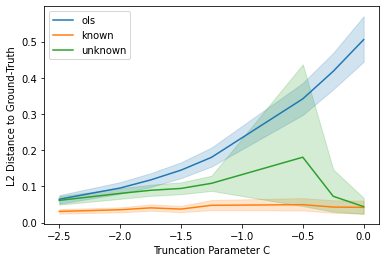

[Text(0.5, 0, 'Truncation Parameter C'),
 Text(0, 0.5, 'L1 Distance to Ground-Truth')]

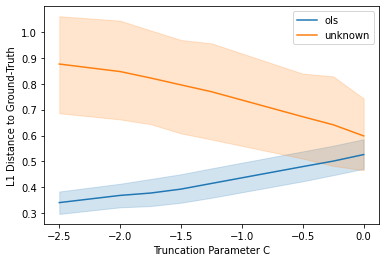

In [58]:
sns.lineplot(data=logs, x='c', y='ols_param_mse', label='ols')
ax = sns.lineplot(data=logs, x='c', y='known_param_mse', label='known')
ax = sns.lineplot(data=logs, x='c', y='unknown_param_mse', label='unknown')
ax.set(xlabel='Truncation Parameter C', ylabel='L2 Distance to Ground-Truth')
plt.show()

sns.lineplot(data=logs, x='c', y='ols_var_l1', label='ols')
ax = sns.lineplot(data=logs, x='c', y='unknown_var_l1', label='unknown')
ax.set(xlabel='Truncation Parameter C', ylabel='L1 Distance to Ground-Truth')

In [114]:
trunc_ols = LinearRegression().fit(x_trunc, y_trunc)
emp_noise_var = (y_trunc - trunc_ols.predict(x_trunc)).var(0)
emp_noise_var

tensor([0.4925])

In [115]:
emp_noise_scale = ch.sqrt(emp_noise_var / 2)
emp_noise_scale

tensor([0.4962])

In [117]:
(emp_noise_var / 2).pow(.5)

tensor([0.4962])

In [120]:
new_noised = noised / ch.sqrt(emp_noise_var)
new_y_trunc = y_trunc / ch.sqrt(emp_noise_var)

In [121]:
ols = LinearRegression().fit(x_trunc_norm, new_y_trunc)

In [122]:
(new_y_trunc - ols.predict(x_trunc_norm)).var(0)

tensor([1.])

In [112]:
another_ols = LinearRegression()
another_ols.fit(X, noised / noise_scale)

LinearRegression()

In [113]:
(noised - another_ols.predict(X)).var(0)

tensor([1.0035])

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

ax.scatter3D(X[indices][:,0], X[indices][:,1], noised[indices], color="green", alpha=.1)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="red", alpha=.75)

ax.view_init(10, -150)

In [ ]:
cleaned_logs = pd.DataFrame(columns=logs.columns)
for var in range(1, 21):
    noise_scale = logs[logs['noise_scale'] == var].reset_index()
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_mse']].sum(1).idxmax(), inplace=True)
    cleaned_logs = pd.concat([cleaned_logs, noise_scale])
cleaned_logs = cleaned_logs.reset_index()

In [145]:
dist.sample(ch.Size([10000])).norm(dim=-1).max()

tensor(1.6702)

In [154]:
u = Uniform(-1/d, 1/d)

s = u.sample(ch.Size([10000, d]))

In [46]:
(x_trunc@w+w0 - y_trunc)

tensor([[-8.0481],
        [-4.1819],
        [-3.8256],
        ...,
        [ 0.5905],
        [-2.1130],
        [-1.7292]])

In [47]:
unknown_var

tensor([[9.3957]], grad_fn=<MulBackward0>)

In [35]:
gt.weight, gt.bias

(Parameter containing:
 tensor([[0.5118]], requires_grad=True),
 Parameter containing:
 tensor([[0.5949]], requires_grad=True))

In [44]:
ols_params

tensor([0.1744, 2.7350])

In [52]:
ch.abs((x_trunc@w + w0) - y_trunc).mean(0)

tensor([2.5809])

In [68]:
((X@w + w0) - noised).var(0)

tensor([9.8567])

In [58]:
(x_trunc@w + w0 - y_trunc).var(0)

tensor([4.2200])

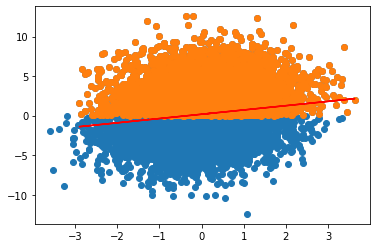

In [89]:
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(x_trunc, x_trunc@w + w0, color='r')

In [61]:
data = Tensor(np.expand_dims(np.linspace(-3, 3), 1))

In [76]:
x_half, y_half = X[:5000], noised[:5000]

In [77]:
(x_half@w + w0 - y_half).var(0)

tensor([10.1086])

In [86]:
(x_trunc@w - y_trunc).var(0)

tensor([4.2200])

In [81]:
w0

tensor([[0.1702]])

In [24]:
rand = ch.randn(100, 16, 1)

In [25]:
rand > 0.0

tensor([[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [ True]],

        [[ True],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [False],
         [False]],

        ...,

        [[False],
         [ True],
         [False],
         ...,
         [False],
         [ True],
         [ True]],

        [[False],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [ True],
         [False]]])